In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from sklearn.impute import SimpleImputer

from tensorflow.keras.callbacks import EarlyStopping
import pickle
from tensorflow.keras.layers import Conv3D, MaxPool3D, Flatten, Dense, ReLU, AveragePooling3D, LeakyReLU, Add
from tensorflow.keras import regularizers

2024-04-18 11:56:53.710011: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-18 11:56:53.929235: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
tf.random.set_seed(1)
import random

import os
random.seed(1)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from sklearn.impute import SimpleImputer

import os
from os import listdir
from os.path import isfile, join

#from keras.engine.topology import Layer
from keras.layers import Activation, Lambda, Conv1D, SpatialDropout1D, add
from tensorflow.keras.layers import Input, Concatenate, Dense
from tensorflow.keras.models import Model

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, concatenate
from tensorflow.keras.models import Model
from sklearn.impute import KNNImputer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Flatten, Dense, Input
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.optimizers import Adadelta, Adam, SGD, Nadam
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

In [4]:
from keras import initializers

np.random.seed(16)
tf.random.set_seed(16)
from sklearn.preprocessing import OneHotEncoder


In [5]:
model_file_path = "/media/gdagasso/TOSHIBA EXT/simulatedTraits_popStruc/Models/"
model_name = "cnn_1d_binaryClassifier.h5"
model_regressed = "mlp_regressed_cnn_output.h5"

cnn_model_path = model_file_path + model_name
regressed_model_path = model_file_path + model_regressed

In [6]:
classes = 3

In [7]:
def fix_sim_geno_file(geno_file, classes, num_inds, num_snps):
    geno_df = pd.read_csv(geno_file,sep=",",index_col=0,header=0)
    print(geno_df.shape)
    
    geno_df = geno_df.drop(columns=['quantitative','binary'])
    
    # Compute the variance of each SNP
    snp_variances = geno_df.var()

    # Identify invariant SNPs (SNPs with zero variance)
    invariant_snps = snp_variances[snp_variances == 0].index
    print(invariant_snps)

    # Remove invariant SNPs from the dataset
    #geno_df = geno_df.drop(columns=invariant_snps)
    
    num_inds = geno_df.shape[0]
    num_snps = geno_df.shape[1]
    
    geno_np = geno_df.to_numpy()
    data_encoded = geno_np.reshape(num_inds, num_snps, 1)
    print(data_encoded.shape)
    
    list_ID = list(geno_df[0:250].index.values)
    
    return data_encoded[0:250], list_ID, geno_df[0:250]

In [8]:
def fix_geno_file(geno_file,classes, same_SNPs_list):
    geno_df = pd.read_csv(geno_file,sep="\t",index_col=2)
    geno_df = geno_df.drop(columns=['#CHROM','POS','REF','ALT','QUAL','FILTER','INFO','FORMAT'])
    print(geno_df.shape)
    
    geno_df_filtered = geno_df[geno_df.index.isin(same_SNPs_list)]
    
    dataframe_T = geno_df_filtered.T
    print(dataframe_T.shape)
    SNPs = len(dataframe_T.columns) #-1 # only drop one when its a revalued vcf file!!
    # Impute with KNN/ Simple
    SI = SimpleImputer(missing_values=9, strategy='most_frequent')
    #knn_imputer = KNNImputer(missing_values='9',n_neighbors=100, weights='uniform', metric='nan_euclidean')
    tmp = SI.fit_transform(dataframe_T)
    dataframe_T_imputed = pd.DataFrame(tmp, columns = dataframe_T.columns, index = dataframe_T.index)
    
    categories = [np.array([0, 1, 2])]*SNPs
    encoder = OneHotEncoder(categories=categories,sparse_output=False)
    data_encoded = encoder.fit_transform(dataframe_T_imputed.to_numpy())
    #print(data_encoded.shape)
    #data_encoded = data_encoded.toarray()
    data_encoded = data_encoded.reshape(-1, 1)
    list_ID = list(dataframe_T_imputed.index.values)
    data_encoded = data_encoded.reshape((len(list_ID),SNPs, classes))
    print(data_encoded.shape)
    
    #list_ID = list(dataframe_T_imputed.index.values) 
    return SNPs, list_ID, data_encoded



In [9]:
def fix_geno_file_noOHE(geno_file, same_SNPs_list):
    geno_df = pd.read_csv(geno_file,sep="\t",index_col=2)
    geno_df = geno_df.drop(columns=['#CHROM','POS','REF','ALT','QUAL','FILTER','INFO','FORMAT'])
    print(geno_df.shape)
    
    geno_df_filtered = geno_df[geno_df.index.isin(same_SNPs_list)]
    
    dataframe_T = geno_df_filtered.T
    print(dataframe_T.shape)
    SNPs = len(dataframe_T.columns) #-1 # only drop one when its a revalued vcf file!!
    # Impute with KNN/ Simple
    SI = SimpleImputer(missing_values=9, strategy='most_frequent')
    #knn_imputer = KNNImputer(missing_values='9',n_neighbors=100, weights='uniform', metric='nan_euclidean')
    tmp = SI.fit_transform(dataframe_T)
    dataframe_T_imputed = pd.DataFrame(tmp, columns = dataframe_T.columns, index = dataframe_T.index)
    np_T_imputed = dataframe_T_imputed.to_numpy()
    #categories = [np.array([0, 1, 2])]*SNPs
    #encoder = OneHotEncoder(categories=categories,sparse_output=False)
    #data_encoded = encoder.fit_transform(dataframe_T_imputed.to_numpy())
    #print(data_encoded.shape)
    #data_encoded = data_encoded.toarray()
    #data_encoded = data_encoded.reshape(-1, 1)
    list_ID = list(dataframe_T_imputed.index.values)
    data_encoded = np_T_imputed.reshape((len(list_ID),SNPs, 1))
    print(data_encoded.shape)
    
    #list_ID = list(dataframe_T_imputed.index.values) 
    return SNPs, list_ID, data_encoded, dataframe_T_imputed

In [10]:
def read_in_popStruc(popStruc_file,list_ID, num_comps):
    pop_struc = pd.read_csv(popStruc_file,sep=",", header=0, index_col=0)
    #pop_struc = pop_struc.drop(columns=['FIID'])
    pop_struc_subset = pop_struc.iloc[:, 0:num_comps]
    
    list_ID_pop = list(pop_struc_subset.index.values)
    merged_list = list(set(list_ID_pop) & set(list_ID))
    
    s = set(merged_list)
    temp3 = [x for x in list_ID if x not in s]
    
    #pop_struc = pop_struc[pop_struc['IID'].isin(list_ID)]
    pop_struc_subset = pop_struc_subset.loc[merged_list]
    #print(pop_struc[:10].head)
    print(pop_struc_subset.shape)
    return pop_struc_subset, temp3

In [11]:
def drop_missing(pids, list_ID, data):
    list_ID_new = list_ID
    print(data.shape)
    for i in pids:
        # Find index of patient ID to drop
        index_to_drop = list_ID.index(i)
        print(i," ",index_to_drop)

        # Drop the respective index from the numpy array
        data_new = np.delete(data, index_to_drop, axis=0)
        
        list_ID_new.remove(i)
        
        print(data_new.shape)
        print(len(list_ID_new))
        
    return data_new, list_ID_new

In [12]:
def reorder(pop_struc,list_ID):
    pop_struc = pop_struc.loc[lst]
    return pop_struc

In [13]:
def geno_cnn_big(inputLayer):
    # Input layer
    #input_layer = Input(shape=(46314, 1))

    # Convolutional layers (FOR BIGGER SNPS DIM)
    conv1 = Conv1D(filters=16, kernel_size=31, activation='relu',name="conv1G")((inputLayer[0]))
    batch_norm1 = BatchNormalization()(conv1)
    max_pooling1 = MaxPooling1D(pool_size=6,name="pool1G")(batch_norm1) #10

    conv2 = Conv1D(filters=32, kernel_size=15, activation='relu', kernel_regularizer=regularizers.l2(0.01),name="conv2G")(max_pooling1)
    batch_norm2 = BatchNormalization()(conv2)
    max_pooling2 = MaxPooling1D(pool_size=3,name="pool2G")(batch_norm2) #6

    #conv3 = Conv1D(filters=64, kernel_size=15, activation='relu',name="conv3G")(max_pooling2)
    #max_pooling3 = MaxPooling1D(pool_size=4, name="pool3G")(conv3)

    #conv4 = Conv1D(filters=128, kernel_size=15, name="conv4G")(max_pooling2)
    #batch_norm4 = BatchNormalization()(conv4)

    # Flatten layer
    flatten = Flatten()(max_pooling2)

    # Dense layers
    dense1 = Dense(512, activation='relu')(flatten)
    x = Dense(256, activation='relu')(dense1)#()
    x = Dropout(.2)(x)
    x = Dense(128, activation='relu')(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    return output_layer
    #return flatten

In [14]:
def geno_big_mlp(inputLayer):
    flatten = Flatten()

In [15]:
def geno_cnn_small(inputLayer):
    # Input layer
    #input_layer = Input(shape=(46314, 1))

    # Convolutional layers
    conv1 = Conv1D(filters=16, kernel_size=3, activation='relu',name="conv1G")((inputLayer[0]))
    batch_norm1 = BatchNormalization()(conv1)
    max_pooling1 = MaxPooling1D(pool_size=4,name="pool1G")(batch_norm1)

    conv2 = Conv1D(filters=32, kernel_size=3, activation='relu',name="conv2G")(max_pooling1)
    batch_norm2 = BatchNormalization()(conv2)
    max_pooling2 = MaxPooling1D(pool_size=3,name="pool2G")(batch_norm2)


    # Flatten layer
    flatten = Flatten()(max_pooling2)

    # Upsampling
    reshaped = Reshape((-1, 1))(flatten)
    upsampled = UpSampling1D(size=2)(reshaped)
    flatten = Flatten(name="flattenUpsample")(upsampled)

    # Dense layers
    dense1 = Dense(28, activation='relu')(flatten)
    #dropped = Dropout(.2)(dense1)
    output_layer = Dense(1, activation='sigmoid')(dense1)
    return output_layer

In [16]:
def compile_model(SNPs,classes):
    opt = Adam(lr=0.001)#,decay=1e-6)
    
    metr = [tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')]
    
    inputA = Input(shape=(SNPs,classes),name="InputA")

    y = geno_cnn_big([inputA])

    model = Model(inputs=[inputA], outputs=[y])
    model.summary()
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=opt, metrics=metr)
    
    return model

In [17]:
def scheduler(epoch, lr):
    #return lr * tf.math.exp(-0.1)
    decay_rate = 0.1
    decay_step = 10  # adjust as needed
    return lr * tf.math.exp(-decay_rate * epoch / decay_step)

In [18]:
def intermediate_model(layer, model):
    layer_output = model.get_layer(layer).output
    model = tf.keras.models.Model(inputs=model.input, outputs=layer_output)
    model.summary()
    return model

In [19]:
def get_outputs(model,data):
    features = model.predict(data)
    print(features.shape)
    return features

In [20]:
def binary_predictor_model(flatten_feature_size):
    # Binary Predictor Model
    input_layer_bp = layers.Input(shape=(flatten_feature_size, 1))  
    flatten = Flatten()(input_layer_bp)
    #dense5 = layers.Dense(600, activation='relu')(input_layer_bp)
    #dense6 = layers.Dense(512,activation='relu')(input_layer_bp)
    #dense7 = layers.Dense(256,activation='relu')(dense6)
    #max_pooling = layers.MaxPooling1D(pool_size=6)(dense6)
    
    
    # Dense layers
    x = Dense(512, activation='relu')(flatten)
    x = Dense(256, activation='relu')(x)#()
    x = Dropout(.2)(x)
    x = Dense(128, activation='relu')(x)
    output_layer = Dense(1, activation='sigmoid')(x)
    
    #output_layer_bp = layers.Dense(1, activation='sigmoid')(dense7)


    binary_predictor_model = Model(input_layer_bp, output_layer, name="binary_predictor")
    binary_predictor_model.summary()
    
    opt = Adam(lr=0.00001)#,decay=1e-6)
    metr = [tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')]
    binary_predictor_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=opt, metrics=metr)
    
    return binary_predictor_model

In [21]:
def binary_predictor_model_noOHE(flatten_feature_size):
    # Binary Predictor Model
    input_layer_bp = layers.Input(shape=(flatten_feature_size))  
    #flatten = Flatten()(input_layer_bp)
    #dense5 = layers.Dense(600, activation='relu')(input_layer_bp)
    #dense6 = layers.Dense(512,activation='relu')(input_layer_bp)
    #dense7 = layers.Dense(256,activation='relu')(dense6)
    #max_pooling = layers.MaxPooling1D(pool_size=6)(dense6)
    
    
    # Dense layers
    #x = Dense(1024, activation='relu')(input_layer_bp)
    #x = Dropout(.2)(x)
    x = Dense(512, activation='relu')(input_layer_bp)
    x = Dense(256, activation='relu')(x)#()
    x = Dropout(.2)(x)
    x = Dense(128, activation='relu')(x)
    output_layer = Dense(1, activation='sigmoid')(x)
    
    #output_layer_bp = layers.Dense(1, activation='sigmoid')(dense7)


    binary_predictor_model = Model(input_layer_bp, output_layer, name="binary_predictor")
    binary_predictor_model.summary()
    
    opt = Adam(lr=0.0001)#,decay=1e-6)
    metr = [tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')]
    binary_predictor_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=opt, metrics=metr)
    
    return binary_predictor_model

In [22]:
# def drop_index(PIDs_to_drop, list_ID, geno_df):
#     for i in PIDs_to_drop:
#         index_to_drop = list_ID.index(PID)
#         geno_df = np.delete(geno_df, index_to_drop, axis=0)
#     print("New Geno Shape: ", geno_df.shape)
#     return geno_df

In [23]:
def convert_preds(test_data, model):
    predictions = model.predict(test_data)
    predictions[predictions < 0.5] = 0
    predictions[predictions > 0.5] = 1
    print(predictions)
    return predictions

In [24]:
def my_confusion_matrix(y_test, predictions):

    accuracy = accuracy_score(y_test, predictions)
    confusion_mat = confusion_matrix(y_test, predictions)
    classification_rep = classification_report(y_test, predictions)

    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", confusion_mat)
    print("Classification Report:\n", classification_rep)

In [25]:
def generate_labels(list_ids_cases, list_ids_controls):
    labels_cases = np.ones(len(list_ids_cases))
    labels_controls = np.zeros(len(list_ids_controls))
    return np.concatenate((labels_cases, labels_controls))


In [26]:
def split_data(list_ids_cases, list_ids_controls, data_cases, data_controls, test_size=0.3, valid_size=0.5, random_state=None):
    # Generate labels
    labels = generate_labels(list_ids_cases, list_ids_controls)
    
    # Combine cases and controls data
    X_combined = np.concatenate((data_cases, data_controls), axis=0)
    list_ids_combined = list_ids_cases + list_ids_controls
    print(len(list_ids_combined))
    
    # Splitting into train, test, and validation sets
    X_train, X_tmp, y_train, y_tmp, ids_train, ids_tmp = train_test_split(X_combined, labels, list_ids_combined, test_size=test_size, random_state=random_state, shuffle=True, stratify=labels)
    print(X_train.shape)
    X_test, X_valid, y_test, y_valid, ids_test, ids_valid = train_test_split(X_tmp, y_tmp, ids_tmp, test_size=valid_size, random_state=random_state, shuffle=True, stratify=y_tmp)
    print(X_test.shape)
    
    return X_train, X_test, X_valid, y_train, y_test, y_valid, ids_train, ids_test, ids_valid

In [27]:
def get_SNPs_merge(geno_file_1,geno_file_0):
    geno_df_1 = pd.read_csv(geno_file_1,sep="\t",index_col=2)
    geno_df_1 = geno_df_1.drop(columns=['#CHROM','POS','REF','ALT','QUAL','FILTER','INFO','FORMAT'])
    list_1 = list(geno_df_1.index.values)
    
    
    geno_df_0 = pd.read_csv(geno_file_0,sep="\t",index_col=2)
    geno_df_0 = geno_df_0.drop(columns=['#CHROM','POS','REF','ALT','QUAL','FILTER','INFO','FORMAT'])
    list_0 = list(geno_df_0.index.values)
    
    join_snps = list(set(list_0).intersection(list_1))
    
    return join_snps
    
    

In [28]:
def split_popStruc(ids_train, ids_test, ids_valid, pop_struc_1,pop_struc_0):
    frames = [pop_struc_1, pop_struc_0]
    result = pd.concat(frames)
    #popStruc_combined = np.concatenate((pop_struc_0,pop_struc_1),axis=0)
    
    train_pop_struc = result.loc[ids_train]
    test_pop_struc = result.loc[ids_test]
    valid_pop_struc = result.loc[ids_valid]
    
    return train_pop_struc,test_pop_struc,valid_pop_struc
    

In [29]:
def save_resids(data,ids,filename):
    resid_train = pd.DataFrame(data, index=ids)
    resid_train.to_csv(filename, index_label='ID')
    print("Saved: ",filename)

In [30]:
def save_split(data, ids, labels, filename):
    # Create DataFrame for residuals data
    #snps = pd.DataFrame(data, index=ids, columns=['Residuals'])

    # Create DataFrame for additional array data
    additional_df = pd.DataFrame({'label': labels}, index=ids)

    # Concatenate DataFrames along columns
    #merged_df = pd.concat([snps, additional_df], axis=1)

    # Save merged DataFrame to CSV
    additional_df.to_csv(filename, index_label='ID')

    print("Saved:", filename)

In [31]:
def plot_loss(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_loss) + 1)

    # Plotting the training and validation loss
    plt.plot(epochs, train_loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [32]:
# Define a function to get the gradients of the output with respect to the input
@tf.function
def get_gradients(model, inputs):
    with tf.GradientTape() as tape:
        inputs = tf.convert_to_tensor(inputs)
        tape.watch(inputs)
        predictions = model(inputs)
    grads = tape.gradient(predictions, inputs)
    return grads

# Define a function to calculate Grad-CAM for a 1D input vector
def calculate_grad_cam_1d(model, inputs, class_idx):
    grads = get_gradients(model, inputs)
    pooled_grads = tf.reduce_mean(grads, axis=0)
    cam = pooled_grads * inputs
    return cam.numpy()

In [112]:
def plot_gradCam(test_data_features,y_test,sample_id, loaded_model):
    # Prepare a sample input (adjust as needed)
    sample_input = test_data_features[sample_id:sample_id+1].astype(np.float32)

    # Choose a class index for which you want to compute Grad-CAM (0 or 1 for binary classification)
    class_index = y_test[sample_id:sample_id+1]
    print(class_index)

    # Compute Grad-CAM for the 1D input vector
    grad_cam = calculate_grad_cam_1d(loaded_model, sample_input, class_index)


    # Visualize the Grad-CAM heatmap (1D signal)
    plt.figure(figsize=(10, 3))
    plt.plot(abs(grad_cam[0]))
    #plt.title('Grad-CAM Heatmap (1D Signal)')
    plt.xlabel('Variant Position')
    plt.ylabel('|Grad-CAM Value|')
    plt.show()

    print(sample_input.shape)

    print(grad_cam.shape)  
    print(grad_cam)        
    
    return grad_cam

In [116]:
def norm(data):
    return (data)/(max(data)-min(data))

In [119]:
def plot_gradCam_ind_overlay(test_data_features1, test_data_features2, y_test, sample_id, loaded_model1, loaded_model2):
    # Prepare sample inputs for both versions (adjust as needed)
    sample_input1 = test_data_features1[sample_id:sample_id+1].astype(np.float32)
    sample_input2 = test_data_features2[sample_id:sample_id+1].astype(np.float32)

    # Choose a class index for which you want to compute Grad-CAM (0 or 1 for binary classification)
    class_index = y_test[sample_id:sample_id+1]

    # Compute Grad-CAM for the 1D input vector for both models and versions
    grad_cam1 = calculate_grad_cam_1d(loaded_model1, sample_input1, class_index)
    grad_cam2 = calculate_grad_cam_1d(loaded_model2, sample_input2, class_index)

    # Visualize the Grad-CAM heatmaps (1D signals) from both models and versions
    plt.figure(figsize=(10, 6))
    plt.plot(norm(abs(grad_cam1[0])), label='Non-regressed input')
    plt.plot(norm(abs(grad_cam2[0])), label='Regressed input')
    plt.xlabel('Variant Position')
    plt.ylabel('|Grad-CAM Value|')
    plt.legend()
    plt.show()

    return grad_cam1, grad_cam2


In [34]:
def plot_gradCam_average(test_data_features, y_test, label, loaded_model, output_to_flatten = False):
    # Filter samples based on the label
    indices = np.where(y_test == label)[0]
    if len(indices) == 0:
        print(f"No samples found with label {label}")
        return

    # Prepare the input data for the selected samples
    #sample_inputs = test_data_features[indices].astype(np.float32)
    #print(sample_inputs.shape)

    # Compute Grad-CAM for each input sample
    grad_cams = []
    if not output_to_flatten:
        for index in indices:
            sample_input = test_data_features[index:index+1].astype(np.float32)
            # Compute Grad-CAM for the 1D input vector
            class_index = np.array([[label]])  # Class index for binary classification
            grad_cam = calculate_grad_cam_1d(loaded_model, sample_input, class_index)
            grad_cams.append(grad_cam)
    else:
        sample_inputs = test_data_features[indices].astype(np.float32)
        #print(sample_inputs.shape)
        
        for sample_input in sample_inputs:
            #print(sample_input.shape)
            reshaped_sample = sample_input.reshape(1, -1)
            #print(reshaped_sample.shape)
            # Compute Grad-CAM for the 1D input vector
            class_index = np.array([[label]])  # Class index for binary classification
            grad_cam = calculate_grad_cam_1d(loaded_model, reshaped_sample, class_index)
            grad_cams.append(grad_cam)

    # Average the Grad-CAM values over all samples
    avg_grad_cam = np.mean(grad_cams, axis=0)

    # Visualize the averaged Grad-CAM heatmap (1D signal)
    plt.figure(figsize=(10, 3))
    plt.plot(avg_grad_cam[0])
    plt.title(f'Averaged Grad-CAM Heatmap for Label {label} (1D Signal)')
    plt.xlabel('Input Position')
    plt.ylabel('Average Grad-CAM Value')
    plt.show()

    return avg_grad_cam


In [59]:
def plot_gradCam_average_manPlot(test_data_features, y_test, label, loaded_model, output_to_flatten = False):
    # Filter samples based on the label
    indices = np.where(y_test == label)[0]
    if len(indices) == 0:
        print(f"No samples found with label {label}")
        return

    # Prepare the input data for the selected samples
    #sample_inputs = test_data_features[indices].astype(np.float32)
    #print(sample_inputs.shape)

    # Compute Grad-CAM for each input sample
    grad_cams = []
    if not output_to_flatten:
        for index in indices:
            sample_input = test_data_features[index:index+1].astype(np.float32)
            # Compute Grad-CAM for the 1D input vector
            class_index = np.array([[label]])  # Class index for binary classification
            grad_cam = calculate_grad_cam_1d(loaded_model, sample_input, class_index)
            grad_cams.append(grad_cam)
    else:
        sample_inputs = test_data_features[indices].astype(np.float32)
        #print(sample_inputs.shape)
        
        for sample_input in sample_inputs:
            #print(sample_input.shape)
            reshaped_sample = sample_input.reshape(1, -1)
            #print(reshaped_sample.shape)
            # Compute Grad-CAM for the 1D input vector
            class_index = np.array([[label]])  # Class index for binary classification
            grad_cam = calculate_grad_cam_1d(loaded_model, reshaped_sample, class_index)
            grad_cams.append(grad_cam)

    # Average the Grad-CAM values over all samples
    avg_grad_cam = np.mean(grad_cams, axis=0)

    # Visualize the averaged Grad-CAM heatmap (1D signal)
    plt.figure(figsize=(10, 3))
    plt.plot(abs(avg_grad_cam[0]))
    #plt.title(f'Averaged Grad-CAM Heatmap for Label {label} (1D Signal)')
    plt.xlabel('Variant Position')
    plt.ylabel('|Average Grad-CAM Value|')
    plt.show()

    return avg_grad_cam


In [75]:
def plot_gradCam_individual_scatter(test_data_features, y_test, label, loaded_model, output_to_flatten=False):
    # Filter samples based on the label
    indices = np.where(y_test == label)[0]
    if len(indices) == 0:
        print(f"No samples found with label {label}")
        return

    # Prepare the input data for the selected samples
    if output_to_flatten:
        sample_inputs = test_data_features[indices].astype(np.float32)
    else:
        sample_inputs = [test_data_features[index:index+1].astype(np.float32) for index in indices]

    # Compute Grad-CAM for each input sample
    grad_cams = []
    for sample_input in sample_inputs:
        # Compute Grad-CAM for the 1D input vector
        class_index = np.array([[label]])  # Class index for binary classification
        grad_cam = calculate_grad_cam_1d(loaded_model, sample_input, class_index)
        grad_cams.append(grad_cam)

    # Prepare scatter plot data
    variant_positions = np.arange(len(grad_cams[0][0]))  # Assuming all Grad-CAMs have the same length
    grad_cam_values = [abs(grad_cam[0]) for grad_cam in grad_cams]

    # Plot individual Grad-CAM values as scatter plot
    plt.figure(figsize=(10, 5))
    for i, grad_cam_value in enumerate(grad_cam_values):
        plt.scatter(variant_positions, grad_cam_value, label=f'Sample {indices[i]}', color='blue')

    plt.xlabel('Variant Position')
    plt.ylabel('|Grad-CAM Value|')
    plt.title(f'Individual Grad-CAM Values for Label {label}')
    #plt.legend()
    plt.show()

    return grad_cam_values


In [35]:
def print_peaks(dataframe, grad_cam, threshold = 1.0e-07):
    max_index = np.argmax(grad_cam)
    print(max_index)

    grad_cam_flat = grad_cam.flatten()
    print(grad_cam_flat)
    abs_grad_cam_flat = np.absolute(grad_cam_flat)
    peaks, _ = find_peaks(abs_grad_cam_flat, height=threshold)  # Adjust the 'height' threshold as needed
    print("Peak Indices:", peaks)
    
    
    for peak_index in peaks:
        print("Peak Index:", peak_index)
        print("Column Name:", dataframe.columns[peak_index])
        print("Grad-CAM Value:", grad_cam_flat[peak_index])#iloc[:,peak_index])
    
    print("VEP:\n")
    for peak_index in peaks:
        print(dataframe.columns[peak_index])

In [80]:
def print_top_values(dataframe, grad_cam, top_n=500):
    grad_cam_flat = grad_cam.flatten()
    abs_grad_cam_flat = np.absolute(grad_cam_flat)

    # Get indices of top 500 values
    top_indices = np.argsort(abs_grad_cam_flat)[-top_n:]

    print("Top 500 Indices:", top_indices)

    # Print top 500 values
    print("Top 500 Values:")
    for index in top_indices:
        print("Column Name:", dataframe.columns[index])
        print("Grad-CAM Value:", grad_cam_flat[index])

    print("VEP:")
    for index in top_indices:
        print(dataframe.columns[index])


In [36]:
# edited this to allow for skipping invariant columns 
# (some simulated data had all the same values for certain positions which caused problems!!!)
def log_reg_first_layer(X_train, X_test, X_valid, X_train_popStruc, X_test_popStruc, X_valid_popStruc):
    
    # REGRESSION

    # Residuals
    # Initialize empty arrays to store residuals
    resid_train = np.zeros_like(X_train)
    resid_test = np.zeros_like(X_test)
    resid_valid = np.zeros_like(X_valid)

    log_models = []

    snp_variances = np.var(X_train, axis=0)
    # Loop through each feature in the features from flatten layer ie chr 5 flatten layer is 13504
    for i in range(X_train.shape[1]):
        if snp_variances[i] > 0:
            #y = layers.Dense(units=20, activation="linear")(population_structure_input)

            # fit linear model for current feature[i]
            lm = LogisticRegression(multi_class='multinomial',solver='saga', max_iter=10000).fit(X_train_popStruc, X_train[:,i].ravel())

            # Save the linear model
            log_models.append(lm)

            # predict features explained by population structure
            p_train = lm.predict(X_train_popStruc)#train_data_all_r_features[:,i])
            p_test = lm.predict(X_test_popStruc)#test_data_all_r_features[:,i])
            p_valid= lm.predict(X_valid_popStruc)#valid_data_all_r_features[:,i])


            #print(p_train.shape)
            #print(X_train[:,i].shape)
            # calculate residuals 
            resid_train[:, i] =  X_train[:,i] - p_train.reshape(-1, 1)
            resid_test[:, i] =  X_test[:,i] - p_test.reshape(-1, 1)
            resid_valid [:, i]=  X_valid[:,i] - p_valid.reshape(-1, 1)

    return resid_train, resid_test, resid_valid, log_models

In [37]:
def binary_predictor_model_noOHE(flatten_feature_size):
    # Binary Predictor Model
    input_layer_bp = layers.Input(shape=(flatten_feature_size))  
    #flatten = Flatten()(input_layer_bp)
    #dense5 = layers.Dense(600, activation='relu')(input_layer_bp)
    #dense6 = layers.Dense(512,activation='relu')(input_layer_bp)
    #dense7 = layers.Dense(256,activation='relu')(dense6)
    #max_pooling = layers.MaxPooling1D(pool_size=6)(dense6)
    
    
    # Dense layers
    #x = Dense(1024, activation='relu')(input_layer_bp)
    #x = Dropout(.2)(x)
    x = Dense(512, activation='relu')(input_layer_bp)
    x = Dense(256, activation='relu')(x)#()
    x = Dropout(.2)(x)
    x = Dense(128, activation='relu')(x)
    output_layer = Dense(1, activation='sigmoid')(x)
    
    #output_layer_bp = layers.Dense(1, activation='sigmoid')(dense7)


    binary_predictor_model = Model(input_layer_bp, output_layer, name="binary_predictor")
    binary_predictor_model.summary()
    
    opt = Adam(lr=0.00001)#,decay=1e-6)
    metr = [tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')]
    binary_predictor_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=opt, metrics=metr)
    
    return binary_predictor_model

In [38]:
def geno_cnn_big(inputLayer):
    # Input layer
    #input_layer = Input(shape=(46314, 1))

    # Convolutional layers (FOR BIGGER SNPS DIM)
    conv1 = Conv1D(filters=16, kernel_size=31, activation='relu',name="conv1G")((inputLayer[0]))
    batch_norm1 = BatchNormalization()(conv1)
    max_pooling1 = MaxPooling1D(pool_size=6,name="pool1G")(batch_norm1) #10

    conv2 = Conv1D(filters=32, kernel_size=15, activation='relu', kernel_regularizer=regularizers.l2(0.01),name="conv2G")(max_pooling1)
    batch_norm2 = BatchNormalization()(conv2)
    max_pooling2 = MaxPooling1D(pool_size=3,name="pool2G")(batch_norm2) #6

    #conv3 = Conv1D(filters=64, kernel_size=15, activation='relu',name="conv3G")(max_pooling2)
    #max_pooling3 = MaxPooling1D(pool_size=4, name="pool3G")(conv3)

    #conv4 = Conv1D(filters=128, kernel_size=15, name="conv4G")(max_pooling2)
    #batch_norm4 = BatchNormalization()(conv4)

    # Flatten layer
    flatten = Flatten()(max_pooling2)

    # Dense layers
    dense1 = Dense(512, activation='relu')(flatten)
    x = Dense(256, activation='relu')(dense1)#()
    x = Dropout(.2)(x)
    x = Dense(128, activation='relu')(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    return output_layer
    #return flatten

In [39]:
num_inds = 2000
num_snps = 10000
num_comps = 10

In [40]:
geno_file_1 = "/media/gdagasso/TOSHIBA EXT/simulatedTraits_popStruc/genotype_herit07_causal500_10000loci_1000ind_3subpops_causal_coeffs_1.csv"
geno_file_0 = "/media/gdagasso/TOSHIBA EXT/simulatedTraits_popStruc/genotype_herit07_causal500_10000loci_1000ind_3subpops_causal_coeffs_0.csv"

In [41]:
SNPs_1, list_ID_1, geno_df_1 = fix_sim_geno_file(geno_file_1, classes, num_inds, num_snps)
SNPs_0, list_ID_0, geno_df_0 = fix_sim_geno_file(geno_file_0, classes, num_inds, num_snps)

(790, 10002)
Index(['76', '440', '615', '729', '1237', '1582', '1867', '2504', '2624',
       '2800', '3733', '4946', '5655', '5771', '5830', '6421', '6672', '6732',
       '6883', '7073', '7166', '7283', '7290', '7756', '8007', '8058'],
      dtype='object')
(790, 10000, 1)
(210, 10002)
Index(['1', '97', '135', '177', '187', '199', '241', '250', '261', '350',
       ...
       '9710', '9725', '9744', '9781', '9836', '9866', '9907', '9916', '9917',
       '9957'],
      dtype='object', length=401)
(210, 10000, 1)


In [42]:
print(geno_df_1.shape)

(250, 10000)


In [70]:
# SNPs_1 = SNPs_1[0:250,]
# list_ID_1 = list(list_ID_1[0:250])

In [43]:
print(SNPs_1.shape)

(250, 10000, 1)


In [44]:
pop_struc_file ="/media/gdagasso/TOSHIBA EXT/simulatedTraits_popStruc/genotype_20000loci_5000ind_3subpops_popStruc.csv"

In [45]:
pop_struc_1, missing_1 = read_in_popStruc(pop_struc_file, list_ID_1, num_comps)
pop_struc_0, missing_0 = read_in_popStruc(pop_struc_file, list_ID_0, num_comps)
print(missing_1)
print(missing_0)

(250, 10)
(210, 10)
[]
[]


In [46]:
print(pop_struc_1.shape)

(250, 10)


In [47]:
print(pop_struc_1)

           PC1        PC2       PC3       PC4       PC5       PC6       PC7  \
1   -40.832678 -36.568523 -1.179781  0.913835 -0.228087  1.842896 -1.481231   
2   -40.688082 -36.135611 -1.639455 -3.088981  2.387784 -0.205551  1.615989   
3   -39.618163 -37.032786  0.260461  1.756589  0.538485  4.361389  1.082162   
4   -40.697077 -36.115132  1.036907  2.960727 -0.847022  0.003425  3.901366   
5   -40.814023 -35.793333  1.162627  4.294309  3.009553  0.392770 -1.157261   
..         ...        ...       ...       ...       ...       ...       ...   
258 -40.597205 -34.067143 -1.043772 -0.324573 -0.831846  1.018262 -0.729498   
259 -40.215123 -34.832661 -1.114493 -1.752178 -1.185628 -3.300127 -1.566032   
260 -40.613079 -34.102276  1.572256  2.486065  1.133658  1.098834 -0.012264   
261 -40.892269 -33.474125  0.196637 -0.208797  1.146727  1.621391  0.523974   
262 -40.744046 -34.149685  0.533586  0.100463  1.466738  0.362612 -0.618907   

          PC8       PC9      PC10  
1    0.093375 -

In [48]:
#geno_df_0_dropped, list_ID_0_dropped = drop_missing(missing_0, list_ID_0, geno_df_0)

# Split Data

In [48]:
X_train, X_test, X_valid, y_train, y_test, y_valid, ids_train, ids_test, ids_valid = split_data(list_ID_1, list_ID_0, SNPs_1, SNPs_0, test_size=0.3, valid_size=0.5, random_state=None)

460
(322, 10000, 1)
(69, 10000, 1)


In [49]:
print(y_train.shape)

(322,)


In [85]:
save_split(X_train,ids_train,y_train,"/media/gdagasso/TOSHIBA EXT/simulatedTraits_popStruc/TRAIN_sim_trait_ids_1000inds.csv")
save_split(X_test,ids_test,y_test,"/media/gdagasso/TOSHIBA EXT/simulatedTraits_popStruc/TEST_sim_trait_ids_1000inds.csv")
save_split(X_valid,ids_valid,y_valid,"/media/gdagasso/TOSHIBA EXT/simulatedTraits_popStruc/VALID_sim_trait_ids_1000inds.csv")


Saved: /media/gdagasso/TOSHIBA EXT/simulatedTraits_popStruc/TRAIN_sim_trait_ids_1000inds.csv
Saved: /media/gdagasso/TOSHIBA EXT/simulatedTraits_popStruc/TEST_sim_trait_ids_1000inds.csv
Saved: /media/gdagasso/TOSHIBA EXT/simulatedTraits_popStruc/VALID_sim_trait_ids_1000inds.csv


In [50]:
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

unique, counts = np.unique(y_valid, return_counts=True)
print(dict(zip(unique, counts)))

{0.0: 147, 1.0: 175}
{0.0: 32, 1.0: 37}


In [51]:
print(X_train.shape)
print(y_train.shape)
#print(ids_train.shape)
#y_train = y_train.reshape(-1, 1)
#y_valid = y_valid.reshape(-1, 1)
#print(y_train.shape)

(322, 10000, 1)
(322,)


In [52]:
# popStruc
X_train_popStruc, X_test_popStruc, X_valid_popStruc = split_popStruc(ids_train, ids_test, ids_valid, pop_struc_1,pop_struc_0)

In [53]:
print(X_train_popStruc.shape)
print(X_test_popStruc.shape)

(322, 10)
(69, 10)


# CNN - no regress

In [90]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)


In [104]:
model = compile_model(num_snps,1)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputA (InputLayer)         [(None, 10000, 1)]        0         
                                                                 
 conv1G (Conv1D)             (None, 9970, 16)          512       
                                                                 
 batch_normalization_2 (Batc  (None, 9970, 16)         64        
 hNormalization)                                                 
                                                                 
 pool1G (MaxPooling1D)       (None, 1661, 16)          0         
                                                                 
 conv2G (Conv1D)             (None, 1647, 32)          7712      
                                                                 
 batch_normalization_3 (Batc  (None, 1647, 32)         128       
 hNormalization)                                           

In [105]:
model_file_path = "/media/gdagasso/TOSHIBA EXT/simulatedTraits_popStruc/Models/"
model_name = "cnn_1d_binaryClassifier_10000_1000inds_lr1e3"
#model_regressed = "mlp_regressed_cnn_output.h5"

cnn_model_path = model_file_path + model_name
#regressed_model_path = model_file_path + model_regressed

In [106]:
from datetime import datetime

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 13:55:58


In [107]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"{cnn_model_path}_epoch{{epoch}}_loss{{val_loss:.4f}}_acc{{val_accuracy:.4f}}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.h5"
                                                         , monitor='val_loss', verbose=2, save_best_only=True, include_optimizer=True, save_weights_only=False, mode='auto',
                                                         save_freq='epoch')

In [108]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define a learning rate scheduler callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss',  # Monitor validation loss
                              factor=0.2,          # Factor by which the learning rate will be reduced
                              patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
                              min_lr=0.00001)      # Lower bound on the learning rate


In [97]:
print(X_train[:,1])

[[0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]


In [109]:
history = model.fit(X_train, y_train, batch_size = 12,epochs=80, validation_data=(X_valid,y_valid),
                    callbacks=[checkpoint_callback,reduce_lr], verbose=2) #lr_callback, checkpoint_callback, lr_callback tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),

Epoch 1/80

Epoch 1: val_loss improved from inf to 4.40438, saving model to /media/gdagasso/TOSHIBA EXT/simulatedTraits_popStruc/Models/cnn_1d_binaryClassifier_10000_1000inds_lr1e3_epoch1_loss4.4044_acc0.4638_20240403_135559.h5
27/27 - 1s - loss: 1.6295 - accuracy: 0.8230 - precision: 0.8352 - recall: 0.8400 - val_loss: 4.4044 - val_accuracy: 0.4638 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010 - 813ms/epoch - 30ms/step
Epoch 2/80

Epoch 2: val_loss improved from 4.40438 to 0.56389, saving model to /media/gdagasso/TOSHIBA EXT/simulatedTraits_popStruc/Models/cnn_1d_binaryClassifier_10000_1000inds_lr1e3_epoch2_loss0.5639_acc0.8841_20240403_135559.h5
27/27 - 0s - loss: 0.4180 - accuracy: 0.9565 - precision: 0.9497 - recall: 0.9714 - val_loss: 0.5639 - val_accuracy: 0.8841 - val_precision: 0.8222 - val_recall: 1.0000 - lr: 0.0010 - 209ms/epoch - 8ms/step
Epoch 3/80

Epoch 3: val_loss did not improve from 0.56389
27/27 - 0s - loss: 0.2344 - accuracy: 0.9938 - precision: 

Epoch 30/80

Epoch 30: val_loss did not improve from 0.56389
27/27 - 0s - loss: 0.1629 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.9631 - val_accuracy: 0.8841 - val_precision: 0.8222 - val_recall: 1.0000 - lr: 1.0000e-05 - 95ms/epoch - 4ms/step
Epoch 31/80

Epoch 31: val_loss did not improve from 0.56389
27/27 - 0s - loss: 0.1627 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.9764 - val_accuracy: 0.8841 - val_precision: 0.8222 - val_recall: 1.0000 - lr: 1.0000e-05 - 95ms/epoch - 4ms/step
Epoch 32/80

Epoch 32: val_loss did not improve from 0.56389
27/27 - 0s - loss: 0.1625 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.9867 - val_accuracy: 0.8841 - val_precision: 0.8222 - val_recall: 1.0000 - lr: 1.0000e-05 - 95ms/epoch - 4ms/step
Epoch 33/80

Epoch 33: val_loss did not improve from 0.56389
27/27 - 0s - loss: 0.1624 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.9980 - val_accuracy: 0.8841 - 

27/27 - 0s - loss: 0.1560 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.0377 - val_accuracy: 0.8841 - val_precision: 0.8222 - val_recall: 1.0000 - lr: 1.0000e-05 - 93ms/epoch - 3ms/step
Epoch 61/80

Epoch 61: val_loss did not improve from 0.56389
27/27 - 0s - loss: 0.1557 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.0374 - val_accuracy: 0.8841 - val_precision: 0.8222 - val_recall: 1.0000 - lr: 1.0000e-05 - 93ms/epoch - 3ms/step
Epoch 62/80

Epoch 62: val_loss did not improve from 0.56389
27/27 - 0s - loss: 0.1554 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.0374 - val_accuracy: 0.8841 - val_precision: 0.8222 - val_recall: 1.0000 - lr: 1.0000e-05 - 96ms/epoch - 4ms/step
Epoch 63/80

Epoch 63: val_loss did not improve from 0.56389
27/27 - 0s - loss: 0.1551 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.0354 - val_accuracy: 0.8841 - val_precision: 0.8222 - val_recall: 1.0000 - lr: 1.0000e-05 -

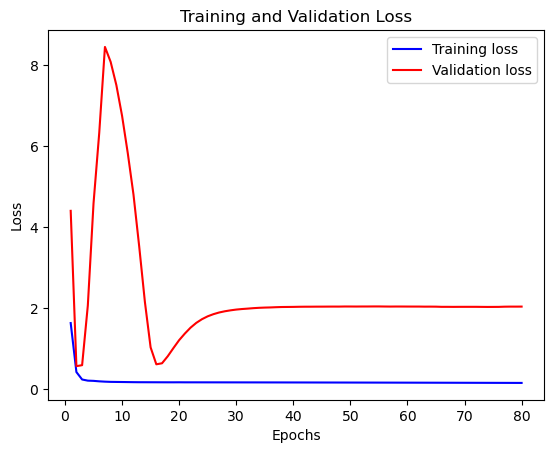

In [110]:
plot_loss(history)

In [99]:
from tensorflow.keras.models import load_model

loaded_model_nonRegress = load_model("/media/gdagasso/TOSHIBA EXT/simulatedTraits_popStruc/Models/cnn_1d_binaryClassifier_10000_1000inds_lr1e3_epoch2_loss0.5639_acc0.8841_20240403_135559.h5")#""/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/cnn_1d_binaryClassifier_noOHE_lr1e3_epoch5_loss0.5344_acc0.8725_20240216_112515.h5")#"/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/cnn_1d_binaryClassifier.h5_epoch4_loss0.7019_acc0.7647_20240214_191738.h5")
loaded_model_nonRegress.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputA (InputLayer)         [(None, 10000, 1)]        0         
                                                                 
 conv1G (Conv1D)             (None, 9970, 16)          512       
                                                                 
 batch_normalization_2 (Batc  (None, 9970, 16)         64        
 hNormalization)                                                 
                                                                 
 pool1G (MaxPooling1D)       (None, 1661, 16)          0         
                                                                 
 conv2G (Conv1D)             (None, 1647, 32)          7712      
                                                                 
 batch_normalization_3 (Batc  (None, 1647, 32)         128       
 hNormalization)                                           

In [100]:
#predictions = loaded_model.predict(X_test)
predictions_binary = convert_preds(X_test,loaded_model_nonRegress)

#print("predictions2 ", predictions_binary.size)
#print("labels", test['PD.x'].values.size)

my_confusion_matrix(y_test,predictions_binary)

3/3 [==============================] - 0s 2ms/step
[[0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]]
Accuracy: 0.9565217391304348
Confusion Matrix:
 [[28  3]
 [ 0 38]]
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.90      0.95        31
         1.0       0.93      1.00      0.96        38

    accuracy                           0.96        69
   macro avg       0.96      0.95      0.96        69
weighted avg       0.96      0.96      0.96        69



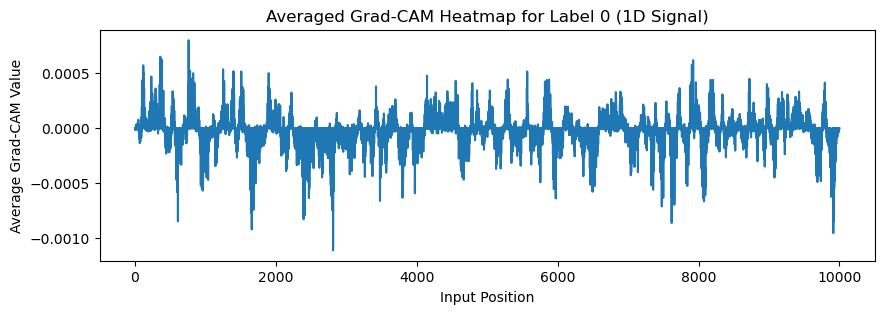

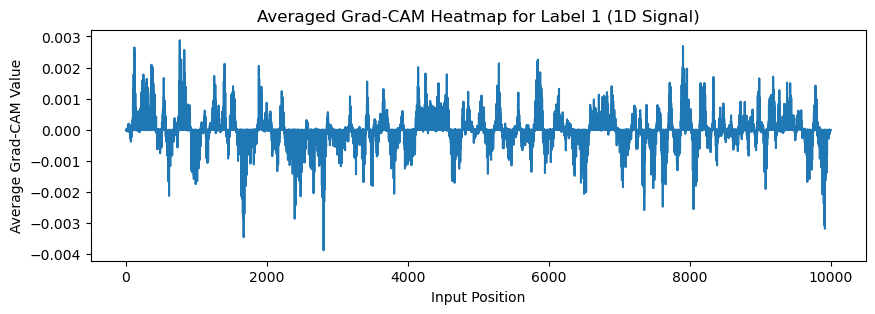

In [101]:
avg_grad_cam_0 = plot_gradCam_average(X_test, y_test, 0, loaded_model_nonRegress)
avg_grad_cam_1 = plot_gradCam_average(X_test,y_test,1,loaded_model_nonRegress)

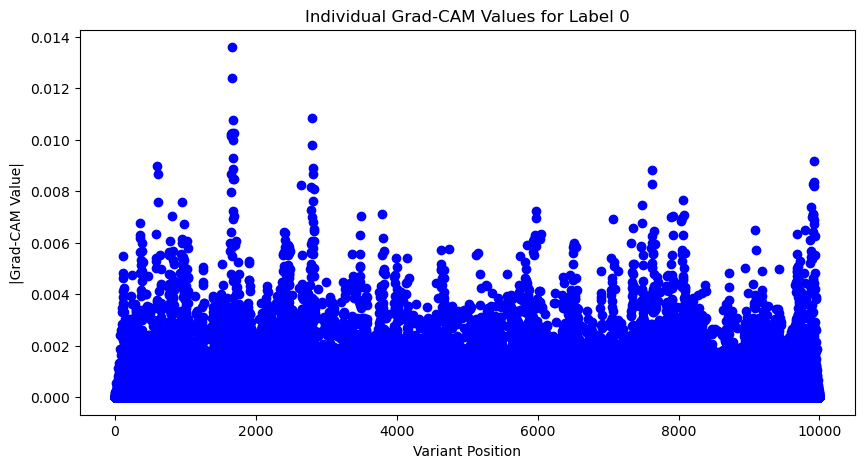

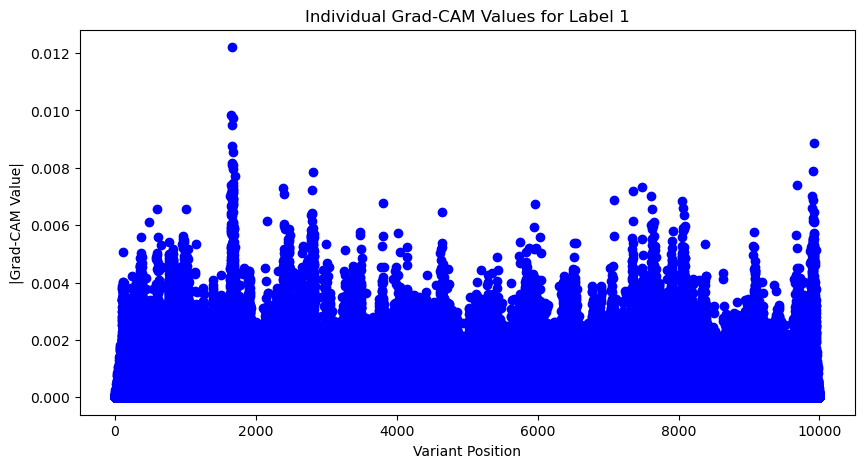

[array([[0.0000000e+00],
        [9.1265980e-07],
        [2.9604498e-06],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]], dtype=float32),
 array([[0.000000e+00],
        [0.000000e+00],
        [7.040453e-06],
        ...,
        [0.000000e+00],
        [0.000000e+00],
        [0.000000e+00]], dtype=float32),
 array([[0.0000000e+00],
        [0.0000000e+00],
        [2.6465868e-06],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]], dtype=float32),
 array([[0.0000000e+00],
        [2.6779153e-06],
        [2.3973338e-05],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]], dtype=float32),
 array([[0.0000000e+00],
        [0.0000000e+00],
        [5.0057224e-07],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]], dtype=float32),
 array([[0.000000e+00],
        [0.000000e+00],
        [5.758684e-06],
        ...,
        [0.000000e+00

In [103]:
plot_gradCam_individual_scatter(X_test, y_test, 0, loaded_model_nonRegress)
plot_gradCam_individual_scatter(X_test,y_test,1,loaded_model_nonRegress)

In [128]:
print_peaks(geno_df_0, avg_grad_cam_0, threshold = 0.0004)
print_peaks(geno_df_1, avg_grad_cam_1, threshold = 0.002)

766
[ 0.0000000e+00  2.5842951e-07 -1.6350693e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
Peak Indices: [ 119  362  602  611  763  766  783  827  832  986 1638 1658 1714 2394
 2412 2657 2787 2789 2804 2813 3798 5754 6457 6495 6502 7621 7624 7644
 7840 7901 7904 8064 8069 8089 9078 9912 9919 9926]
Peak Index: 119
Column Name: 120
Grad-CAM Value: 0.00044655573
Peak Index: 362
Column Name: 363
Grad-CAM Value: 0.0004113
Peak Index: 602
Column Name: 603
Grad-CAM Value: -0.0004357949
Peak Index: 611
Column Name: 612
Grad-CAM Value: -0.000527976
Peak Index: 763
Column Name: 764
Grad-CAM Value: 0.0004614452
Peak Index: 766
Column Name: 767
Grad-CAM Value: 0.0006018247
Peak Index: 783
Column Name: 784
Grad-CAM Value: 0.00049901474
Peak Index: 827
Column Name: 828
Grad-CAM Value: 0.0004476067
Peak Index: 832
Column Name: 833
Grad-CAM Value: 0.0004260594
Peak Index: 986
Column Name: 987
Grad-CAM Value: -0.0006413812
Peak Index: 1638
Column Name: 1639
Grad-CAM Value: -0.00042458836
Peak

In [84]:
print_top_values(geno_df_0, avg_grad_cam_0, 500)
print_top_values(geno_df_1, avg_grad_cam_1, 500)

Top 500 Indices: [4016 1157 8196 1676 7077  115 6536 7883  819 1593 4160 7598 9411 2611
 4317 2079 7483  589  113 7889 1370 6510 6061 2619 1700 5029 5426 6897
 5874 4744 3392  549 4255 6563 3989 8198 1602 7672 5152 4128 3971  644
 6242 5856 9191  994 1928 9204 3772 1004 1490 2769 1038 1161 7613 3270
 3765 2393 1612 2637 6464 2519 3846 3384 4706 1996 3059 5258 5970 7523
 5723 9189  796 3697 9721 8979 9710 8388 6376 3572 8169 3789 4070 7973
 8678 1449 4199 6761  776 5986 6898  968 9934 1646 8185 7338 9669 7053
 7689 3025 6358 6044 1032 7621 9728 1723 2534 4439 3117 2445 6029 5838
 3791 9135 2742 3360 4007  596 9194 1917 9187 8996  835 4597 3785 3747
 7510  301 7668 8929 3815 4729  545 2170 4143 6909 5477 2332 2365 5811
 1739 3577 4670 1497 3964  980 4259 4246 1495 7897 2424 7344 9893  290
 2655 9377 9730 9058 4552  297 9944 3758  130 2648  638  657 1533 6521
 7348 3241 2784 4709 4737 8836 1902 5834 6529 6546  990 1003 6900 7632
 4579  114 8334 1008 4558  935 4673 7081 2156 9700 1011 5868

In [96]:
print(y_test)

[0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1.
 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1.
 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1.]


[0.]


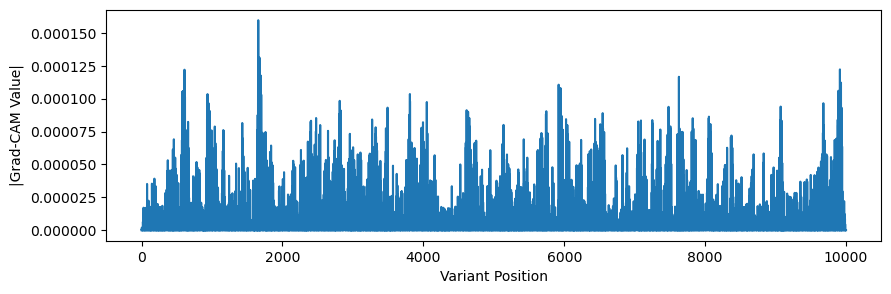

(1, 10000, 1)
(1, 10000, 1)
[[[-0.]
  [ 0.]
  [ 0.]
  ...
  [ 0.]
  [ 0.]
  [ 0.]]]
[1.]


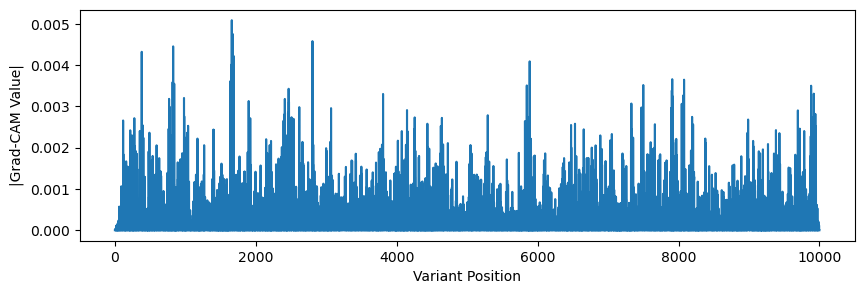

(1, 10000, 1)
(1, 10000, 1)
[[[-0.0000000e+00]
  [-9.1265980e-07]
  [-2.9604498e-06]
  ...
  [ 0.0000000e+00]
  [ 0.0000000e+00]
  [ 0.0000000e+00]]]


array([[[-0.0000000e+00],
        [-9.1265980e-07],
        [-2.9604498e-06],
        ...,
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00]]], dtype=float32)

In [105]:
plot_gradCam(X_test,y_test,0, loaded_model_nonRegress)
plot_gradCam(X_test,y_test,1, loaded_model_nonRegress)

In [85]:
def log_reg_first_layer(X_train, X_test, X_valid, X_train_popStruc, X_test_popStruc, X_valid_popStruc):
    
    # REGRESSION

    # Residuals
    # Initialize empty arrays to store residuals
    resid_train = np.zeros_like(X_train)
    resid_test = np.zeros_like(X_test)
    resid_valid = np.zeros_like(X_valid)

    log_models = []

    snp_variances = np.var(X_train, axis=0)
    # Loop through each feature in the features from flatten layer ie chr 5 flatten layer is 13504
    for i in range(X_train.shape[1]):
        if snp_variances[i] > 0:
            #y = layers.Dense(units=20, activation="linear")(population_structure_input)

            # fit linear model for current feature[i]
            lm = LogisticRegression(multi_class='multinomial',solver='saga', max_iter=10000).fit(X_train_popStruc, X_train[:,i].ravel())

            # Save the linear model
            log_models.append(lm)

            # predict features explained by population structure
            p_train = lm.predict(X_train_popStruc)#train_data_all_r_features[:,i])
            p_test = lm.predict(X_test_popStruc)#test_data_all_r_features[:,i])
            p_valid= lm.predict(X_valid_popStruc)#valid_data_all_r_features[:,i])


            #print(p_train.shape)
            #print(X_train[:,i].shape)
            # calculate residuals 
            resid_train[:, i] =  X_train[:,i] - p_train.reshape(-1, 1)
            resid_test[:, i] =  X_test[:,i] - p_test.reshape(-1, 1)
            resid_valid [:, i]=  X_valid[:,i] - p_valid.reshape(-1, 1)

    return resid_train, resid_test, resid_valid, log_models

In [86]:
print(X_train[:,9])

[[1]
 [1]
 [0]
 [0]
 [1]
 [2]
 [0]
 [2]
 [2]
 [0]
 [2]
 [2]
 [0]
 [2]
 [2]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [2]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [2]
 [0]
 [1]
 [1]
 [1]
 [2]
 [0]
 [1]
 [1]
 [2]
 [1]
 [1]
 [2]
 [1]
 [2]
 [1]
 [2]
 [1]
 [1]
 [2]
 [1]
 [2]
 [2]
 [2]
 [1]
 [1]
 [2]
 [1]
 [1]
 [1]
 [2]
 [0]
 [0]
 [1]
 [1]
 [2]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [2]
 [1]
 [1]
 [2]
 [0]
 [1]
 [1]
 [0]
 [1]
 [2]
 [1]
 [2]
 [2]
 [2]
 [1]
 [1]
 [2]
 [2]
 [1]
 [0]
 [1]
 [1]
 [1]
 [2]
 [1]
 [0]
 [0]
 [2]
 [0]
 [0]
 [2]
 [2]
 [2]
 [1]
 [0]
 [1]
 [2]
 [1]
 [2]
 [2]
 [2]
 [1]
 [2]
 [1]
 [1]
 [2]
 [1]
 [1]
 [2]
 [2]
 [2]
 [2]
 [2]
 [1]
 [0]
 [2]
 [1]
 [2]
 [1]
 [2]
 [1]
 [1]
 [2]
 [1]
 [2]
 [1]
 [2]
 [1]
 [1]
 [2]
 [2]
 [2]
 [1]
 [1]
 [0]
 [1]
 [2]
 [2]
 [0]
 [2]
 [2]
 [2]
 [1]
 [0]
 [1]
 [1]
 [2]
 [2]
 [1]
 [2]
 [2]
 [2]
 [1]
 [0]
 [2]
 [0]
 [2]
 [1]
 [1]
 [2]
 [1]
 [2]
 [1]
 [0]
 [1]
 [2]
 [1]
 [0]
 [0]
 [2]
 [1]
 [2]
 [0]
 [1]
 [2]
 [2]
 [2]
 [0]
 [0]
 [2]
 [0]
 [1]
 [2]
 [1]
 [0]
 [1]


# Regress out

In [87]:
resid_train, resid_test, resid_valid, log_models = log_reg_first_layer(X_train, X_test, X_valid, X_train_popStruc, X_test_popStruc, X_valid_popStruc)

In [88]:
print(resid_test.shape)

(69, 10000, 1)


In [131]:
save_resids(np.squeeze(resid_train),ids_train,"/media/gdagasso/TOSHIBA EXT/simulatedTraits_popStruc/resid_TRAIN_sim_trait_ids_1000inds.csv")
save_resids(np.squeeze(resid_test),ids_test,"/media/gdagasso/TOSHIBA EXT/simulatedTraits_popStruc/resid_TEST_sim_trait_ids_1000inds.csv")
save_resids(np.squeeze(resid_valid),ids_valid,"/media/gdagasso/TOSHIBA EXT/simulatedTraits_popStruc/resid_VALID_sim_trait_ids_1000inds.csv")


Saved:  /media/gdagasso/TOSHIBA EXT/simulatedTraits_popStruc/resid_TRAIN_sim_trait_ids_1000inds.csv
Saved:  /media/gdagasso/TOSHIBA EXT/simulatedTraits_popStruc/resid_TEST_sim_trait_ids_1000inds.csv
Saved:  /media/gdagasso/TOSHIBA EXT/simulatedTraits_popStruc/resid_VALID_sim_trait_ids_1000inds.csv


# CNN - regressed at input layer

In [132]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)


In [134]:
model = compile_model(num_snps,1)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputA (InputLayer)         [(None, 10000, 1)]        0         
                                                                 
 conv1G (Conv1D)             (None, 9970, 16)          512       
                                                                 
 batch_normalization_4 (Batc  (None, 9970, 16)         64        
 hNormalization)                                                 
                                                                 
 pool1G (MaxPooling1D)       (None, 1661, 16)          0         
                                                                 
 conv2G (Conv1D)             (None, 1647, 32)          7712      
                                                                 
 batch_normalization_5 (Batc  (None, 1647, 32)         128       
 hNormalization)                                           

/home/gdagasso/anaconda3/envs/anomalyDetectionTF/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [135]:
model_file_path = "/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/"
model_name = "cnn_1d_binaryClassifier_regressedAtInput_lr1e3"
#model_regressed = "mlp_regressed_cnn_output.h5"

cnn_model_path = model_file_path + model_name
#regressed_model_path = model_file_path + model_regressed

In [136]:
from datetime import datetime

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 14:17:00


In [137]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"{cnn_model_path}_epoch{{epoch}}_loss{{val_loss:.4f}}_acc{{val_accuracy:.4f}}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.h5"
                                                         , monitor='val_loss', verbose=2, save_best_only=True, include_optimizer=True, save_weights_only=False, mode='auto',
                                                         save_freq='epoch')

In [138]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define a learning rate scheduler callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss',  # Monitor validation loss
                              factor=0.2,          # Factor by which the learning rate will be reduced
                              patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
                              min_lr=0.00001)      # Lower bound on the learning rate


In [139]:
history = model.fit(resid_train, y_train, batch_size = 8,epochs=80, validation_data=(resid_valid,y_valid),
                    callbacks=[checkpoint_callback,reduce_lr], verbose=2) #lr_callback, checkpoint_callback, lr_callback tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),

Epoch 1/80

Epoch 1: val_loss improved from inf to 0.81543, saving model to /media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/cnn_1d_binaryClassifier_regressedAtInput_lr1e3_epoch1_loss0.8154_acc0.5652_20240403_141701.h5
41/41 - 1s - loss: 1.4785 - accuracy: 0.8416 - precision: 0.8407 - recall: 0.8743 - val_loss: 0.8154 - val_accuracy: 0.5652 - val_precision: 0.7059 - val_recall: 0.3243 - lr: 0.0010 - 865ms/epoch - 21ms/step
Epoch 2/80

Epoch 2: val_loss did not improve from 0.81543
41/41 - 0s - loss: 0.4253 - accuracy: 0.9565 - precision: 0.9497 - recall: 0.9714 - val_loss: 14.2410 - val_accuracy: 0.4638 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010 - 127ms/epoch - 3ms/step
Epoch 3/80

Epoch 3: val_loss did not improve from 0.81543
41/41 - 0s - loss: 0.2822 - accuracy: 0.9752 - precision: 0.9665 - recall: 0.9886 - val_loss: 27.2507 - val_accuracy: 0.4638 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010 - 126ms/epoch - 3ms/step
Epoch 

Epoch 30/80

Epoch 30: val_loss did not improve from 0.81388
41/41 - 0s - loss: 0.1579 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.7375 - val_accuracy: 0.8841 - val_precision: 0.8222 - val_recall: 1.0000 - lr: 1.0000e-05 - 121ms/epoch - 3ms/step
Epoch 31/80

Epoch 31: val_loss did not improve from 0.81388
41/41 - 0s - loss: 0.1577 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.7373 - val_accuracy: 0.8841 - val_precision: 0.8222 - val_recall: 1.0000 - lr: 1.0000e-05 - 124ms/epoch - 3ms/step
Epoch 32/80

Epoch 32: val_loss did not improve from 0.81388
41/41 - 0s - loss: 0.1575 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.7407 - val_accuracy: 0.8841 - val_precision: 0.8222 - val_recall: 1.0000 - lr: 1.0000e-05 - 123ms/epoch - 3ms/step
Epoch 33/80

Epoch 33: val_loss did not improve from 0.81388
41/41 - 0s - loss: 0.1573 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.7406 - val_accuracy: 0.8841

41/41 - 0s - loss: 0.1497 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.7814 - val_accuracy: 0.8841 - val_precision: 0.8222 - val_recall: 1.0000 - lr: 1.0000e-05 - 127ms/epoch - 3ms/step
Epoch 61/80

Epoch 61: val_loss did not improve from 0.81388
41/41 - 0s - loss: 0.1489 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.7838 - val_accuracy: 0.8841 - val_precision: 0.8222 - val_recall: 1.0000 - lr: 1.0000e-05 - 126ms/epoch - 3ms/step
Epoch 62/80

Epoch 62: val_loss did not improve from 0.81388
41/41 - 0s - loss: 0.1485 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.7828 - val_accuracy: 0.8841 - val_precision: 0.8222 - val_recall: 1.0000 - lr: 1.0000e-05 - 122ms/epoch - 3ms/step
Epoch 63/80

Epoch 63: val_loss did not improve from 0.81388
41/41 - 0s - loss: 0.1481 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.7826 - val_accuracy: 0.8841 - val_precision: 0.8222 - val_recall: 1.0000 - lr: 1.0000e-0

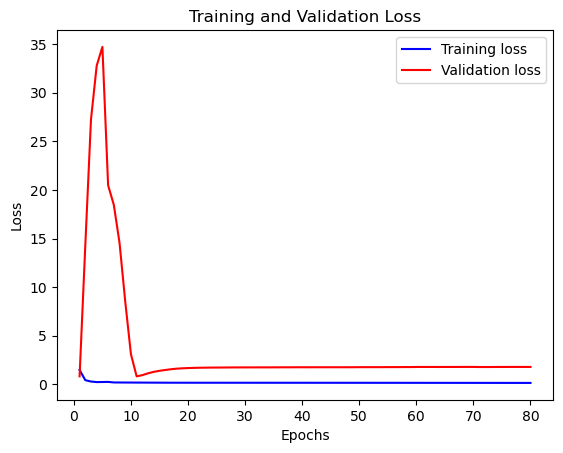

In [140]:
plot_loss(history)

In [141]:
history_dict = history.history

In [107]:
from tensorflow.keras.models import load_model

loaded_model_regress = load_model("/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/cnn_1d_binaryClassifier_regressedAtInput_lr1e3_epoch11_loss0.8139_acc0.8406_20240403_141701.h5")#""/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/cnn_1d_binaryClassifier_noOHE_lr1e3_epoch5_loss0.5344_acc0.8725_20240216_112515.h5")#"/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/cnn_1d_binaryClassifier.h5_epoch4_loss0.7019_acc0.7647_20240214_191738.h5")
loaded_model_regress.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputA (InputLayer)         [(None, 10000, 1)]        0         
                                                                 
 conv1G (Conv1D)             (None, 9970, 16)          512       
                                                                 
 batch_normalization_4 (Batc  (None, 9970, 16)         64        
 hNormalization)                                                 
                                                                 
 pool1G (MaxPooling1D)       (None, 1661, 16)          0         
                                                                 
 conv2G (Conv1D)             (None, 1647, 32)          7712      
                                                                 
 batch_normalization_5 (Batc  (None, 1647, 32)         128       
 hNormalization)                                           

In [90]:
#predictions = loaded_model.predict(X_test)
predictions_binary = convert_preds(resid_test,loaded_model_regress)

#print("predictions2 ", predictions_binary.size)
#print("labels", test['PD.x'].values.size)

my_confusion_matrix(y_test,predictions_binary)

3/3 [==============================] - 0s 2ms/step
[[0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]]
Accuracy: 0.9130434782608695
Confusion Matrix:
 [[29  2]
 [ 4 34]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.94      0.91        31
         1.0       0.94      0.89      0.92        38

    accuracy                           0.91        69
   macro avg       0.91      0.92      0.91        69
weighted avg       0.91      0.91      0.91        69



In [144]:
print(X_test.shape)
print(y_test[:10])

(69, 10000, 1)
[0. 1. 0. 0. 1. 0. 1. 0. 1. 1.]


[1.]


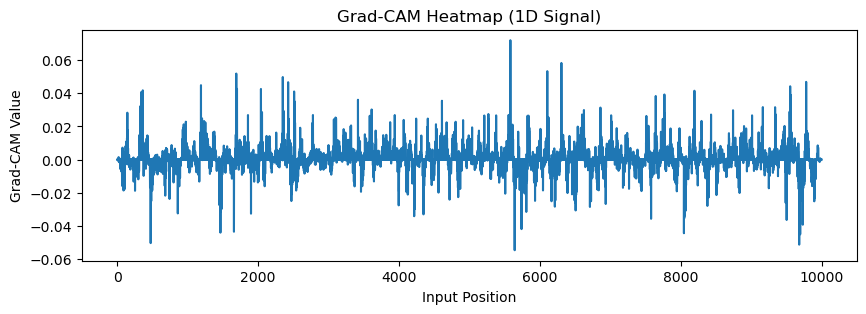

(1, 10000, 1)
(1, 10000, 1)
[[[-0.]
  [-0.]
  [-0.]
  ...
  [ 0.]
  [ 0.]
  [ 0.]]]
[1.]


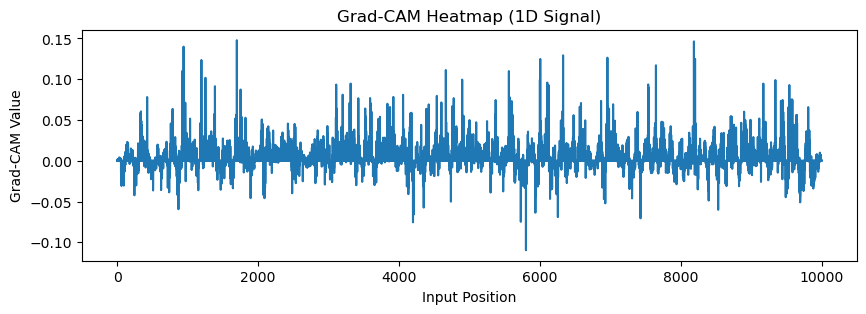

(1, 10000, 1)
(1, 10000, 1)
[[[ 0.        ]
  [ 0.        ]
  [-0.00021107]
  ...
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]]]
[0.]


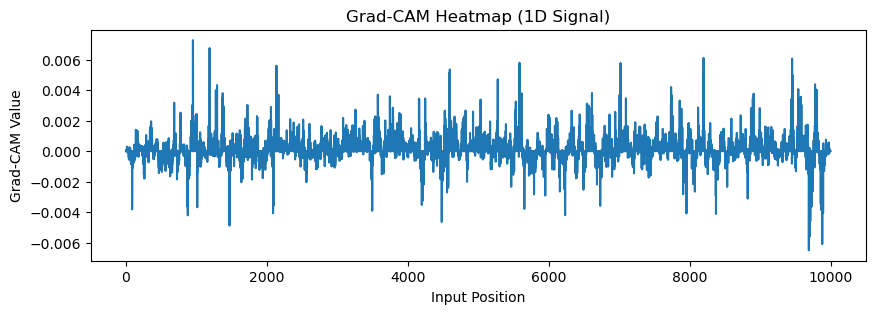

(1, 10000, 1)
(1, 10000, 1)
[[[-0.0000000e+00]
  [ 0.0000000e+00]
  [-2.0042695e-05]
  ...
  [ 0.0000000e+00]
  [-0.0000000e+00]
  [-0.0000000e+00]]]
[0.]


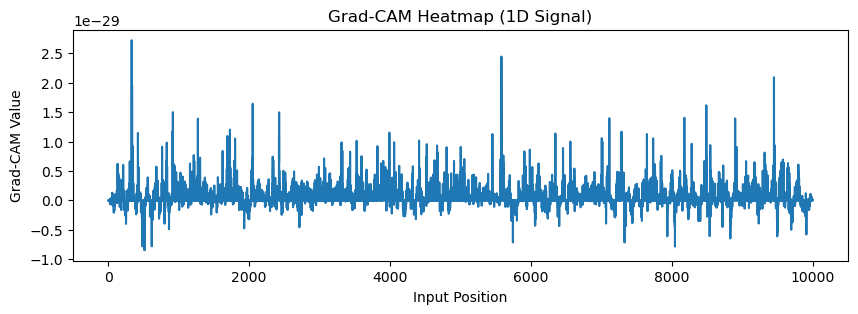

(1, 10000, 1)
(1, 10000, 1)
[[[-0.]
  [ 0.]
  [ 0.]
  ...
  [ 0.]
  [ 0.]
  [ 0.]]]


In [145]:
grad_cam_1 = plot_gradCam(resid_test,y_test,1,loaded_model_regress)
grad_cam_2 = plot_gradCam(resid_test,y_test,4,loaded_model_regress)
grad_cam_3 = plot_gradCam(resid_test,y_test,0,loaded_model_regress)
grad_cam_4 = plot_gradCam(resid_test,y_test,3,loaded_model_regress)

In [146]:
# reshaped_X_resid = np.squeeze(resid_test, axis=2)

In [147]:
# X_resid_df = pd.DataFrame(reshaped_X_resid, columns=df_1.columns, index = ids_test)

NameError: name 'df_1' is not defined

In [148]:
print_peaks(geno_df_0, grad_cam_4, threshold = 0.005)

332
[-0.  0.  0. ...  0.  0.  0.]
Peak Indices: []
VEP:



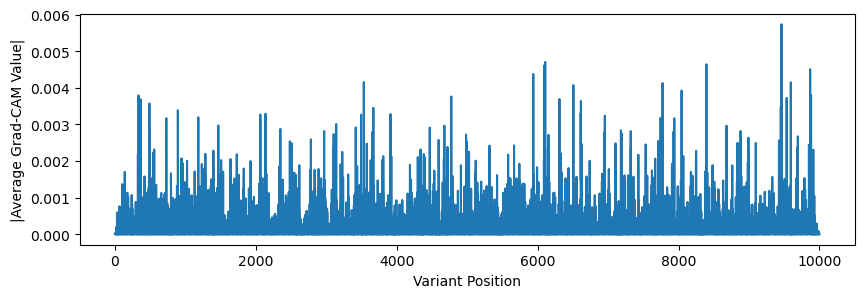

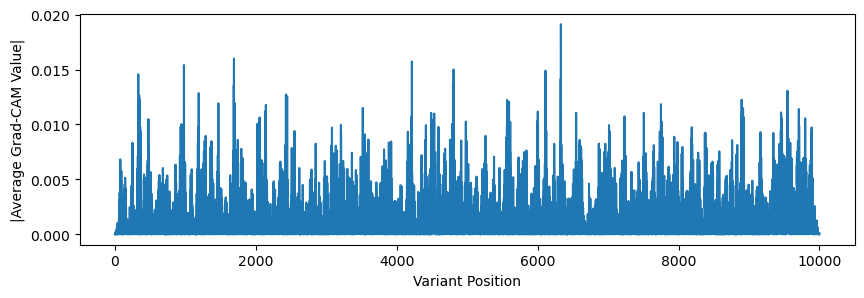

In [91]:
avg_grad_cam_0 = plot_gradCam_average_manPlot(resid_test, y_test, 0, loaded_model_regress)
avg_grad_cam_1 = plot_gradCam_average_manPlot(resid_test,y_test,1,loaded_model_regress)

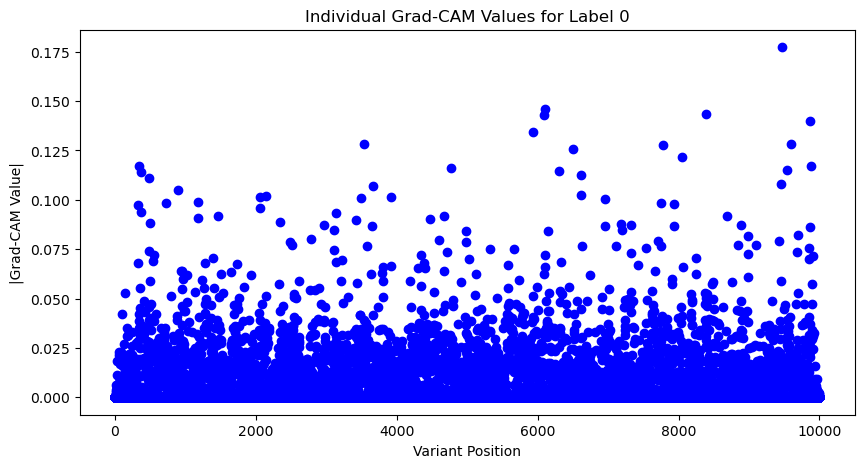

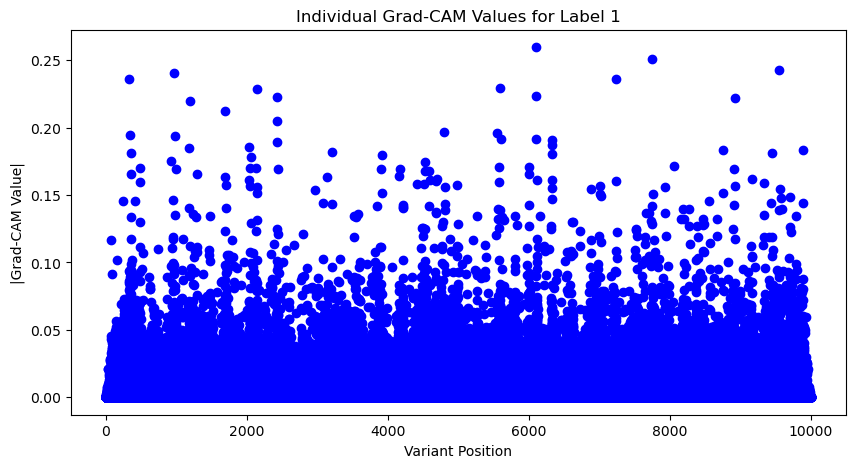

[array([[0.        ],
        [0.        ],
        [0.00012346],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]], dtype=float32),
 array([[0.0000000e+00],
        [0.0000000e+00],
        [5.1596864e-05],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]], dtype=float32),
 array([[0.        ],
        [0.        ],
        [0.00167124],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]], dtype=float32),
 array([[0.00000e+00],
        [4.62772e-05],
        [8.92125e-05],
        ...,
        [0.00000e+00],
        [0.00000e+00],
        [0.00000e+00]], dtype=float32),
 array([[0.0000000e+00],
        [0.0000000e+00],
        [1.7860552e-06],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]], dtype=float32),
 array([[0.000000e+00],
        [0.000000e+00],
        [7.407777e-06],
        ...,
        [0.000000e+00],
        [0.000000e+00],
        [0.0000

In [92]:
plot_gradCam_individual_scatter(resid_test, y_test, 0, loaded_model_regress)
plot_gradCam_individual_scatter(resid_test,y_test,1,loaded_model_regress)


In [93]:
print_top_values(geno_df_0, avg_grad_cam_0, 500)
print_top_values(geno_df_1, avg_grad_cam_1, 500)

Top 500 Indices: [7877 2845 8230  703 9348 4684 4374 5652 6317  911 7930 3548 7516 9893
 6522 9926 6956 1172 6235 3565 5953 9161 9286 3529 7627 7808 1702 1287
 5326 2426 4527 4467 6810 2139 1089 7675 6069 2345 6720 4455  702 3398
 3883  238 7994 1039 2182 2515 5215 3092 2081 7855 7007 6121 8675 5320
 6147 9549 7733 5983 5195 5620 8892 5264  510 4981 8309 5137 3754 3503
 7235 6130 1496 5268 6521 3777 8433 3415 2522 7020 9887 4154 6878 8900
 2052 1701 3489 9545 9350 2083 9536 2183 1682  709 2384 1424 5641  658
 6223  340 5603 6315 1259  177 5512  460 6236 3806 7365 3606 9448 4288
 5153 6119 1327 2467 6321 9551 7352 4208 1484 7839 4372 6164 2526 9223
 1759 9563 1698 2800  473 4569 9755 2529 8573  365 8197 4985 8186 4525
 9289 4868 1478  958 2367 8386 5241 4528 4474 7236 6541 5812 9783 1292
 4428 4339 4321 7532 9866 1326 8036 3078 7647 7000 2126 8989 3564 5735
 9796 6138 8565 5916 2839 2964 3098 1052 7739 6126  553 5056 2905 1821
 5588 1902  345 8509 5537 2966 5607 9444 8376 2582 1450 9543

In [151]:
print_peaks(geno_df_0, avg_grad_cam_0, threshold = 0.004)
print_peaks(geno_df_0, avg_grad_cam_1, threshold = 0.01)

338
[ 0.0000000e+00  2.6045500e-08 -1.0053757e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
Peak Indices: [ 331  336  338  352  931 1683 4539 4665 6105 7234 7761 9797]
Peak Index: 331
Column Name: 332
Grad-CAM Value: 0.0046844655
Peak Index: 336
Column Name: 337
Grad-CAM Value: 0.0061137555
Peak Index: 338
Column Name: 339
Grad-CAM Value: 0.0062454278
Peak Index: 352
Column Name: 353
Grad-CAM Value: 0.0044316505
Peak Index: 931
Column Name: 932
Grad-CAM Value: 0.0044927215
Peak Index: 1683
Column Name: 1684
Grad-CAM Value: 0.0041867606
Peak Index: 4539
Column Name: 4540
Grad-CAM Value: 0.004044658
Peak Index: 4665
Column Name: 4666
Grad-CAM Value: 0.0041300813
Peak Index: 6105
Column Name: 6106
Grad-CAM Value: 0.004883781
Peak Index: 7234
Column Name: 7235
Grad-CAM Value: 0.004777254
Peak Index: 7761
Column Name: 7762
Grad-CAM Value: 0.0048051807
Peak Index: 9797
Column Name: 9798
Grad-CAM Value: 0.0040144725
VEP:

332
337
339
353
932
1684
4540
4666
6106
7235
7762
9798
2428
[ 

[0.]


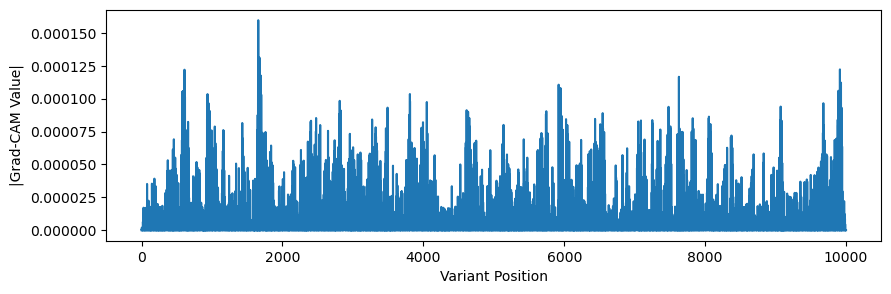

(1, 10000, 1)
(1, 10000, 1)
[[[-0.]
  [ 0.]
  [ 0.]
  ...
  [ 0.]
  [ 0.]
  [ 0.]]]
[0.]


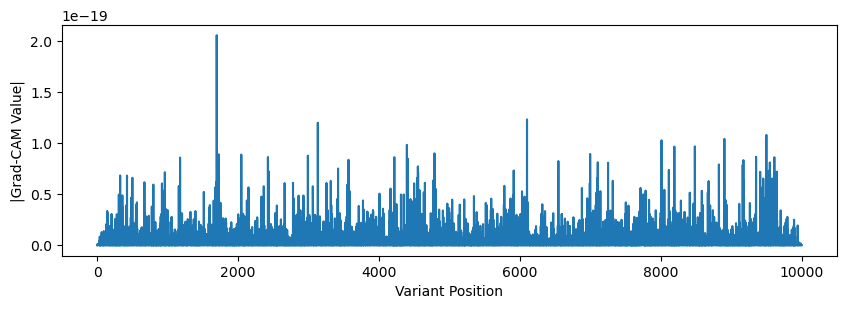

(1, 10000, 1)
(1, 10000, 1)
[[[-0.0000000e+00]
  [ 0.0000000e+00]
  [ 7.7553973e-22]
  ...
  [ 0.0000000e+00]
  [ 0.0000000e+00]
  [-0.0000000e+00]]]
[1.]


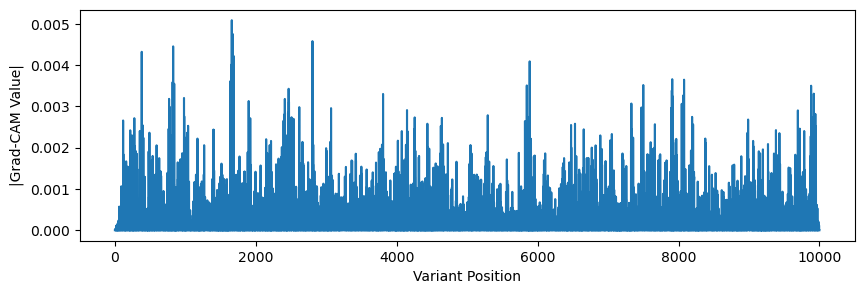

(1, 10000, 1)
(1, 10000, 1)
[[[-0.0000000e+00]
  [-9.1265980e-07]
  [-2.9604498e-06]
  ...
  [ 0.0000000e+00]
  [ 0.0000000e+00]
  [ 0.0000000e+00]]]
[1.]


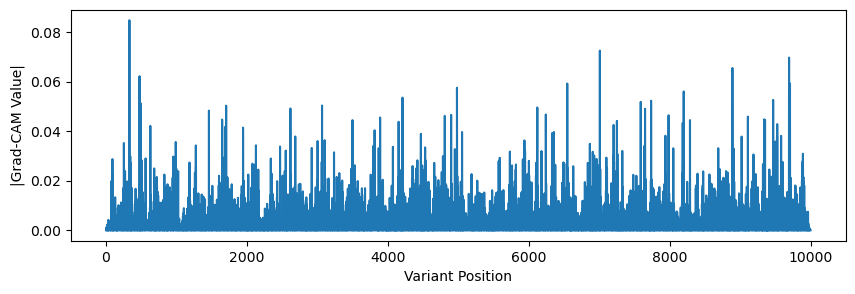

(1, 10000, 1)
(1, 10000, 1)
[[[ 0.        ]
  [-0.        ]
  [-0.00012346]
  ...
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]]]


array([[[ 0.        ],
        [-0.        ],
        [-0.00012346],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]]], dtype=float32)

In [108]:
plot_gradCam(X_test,y_test,0, loaded_model_nonRegress)
plot_gradCam(resid_test,y_test,0, loaded_model_regress)
plot_gradCam(X_test,y_test,1, loaded_model_nonRegress)
plot_gradCam(resid_test,y_test,1, loaded_model_regress)

In [121]:
print(y_test)

[0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1.
 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1.
 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1.]


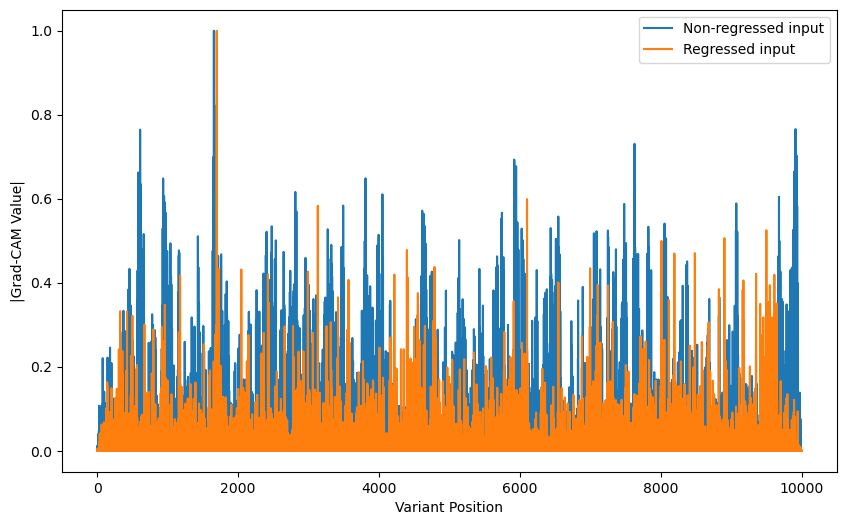

(array([[[-0.],
         [ 0.],
         [ 0.],
         ...,
         [ 0.],
         [ 0.],
         [ 0.]]], dtype=float32),
 array([[[-0.0000000e+00],
         [ 0.0000000e+00],
         [ 7.7553973e-22],
         ...,
         [ 0.0000000e+00],
         [ 0.0000000e+00],
         [-0.0000000e+00]]], dtype=float32))

In [120]:
plot_gradCam_ind_overlay(X_test, resid_test, y_test, 0, loaded_model_nonRegress, loaded_model_regress)

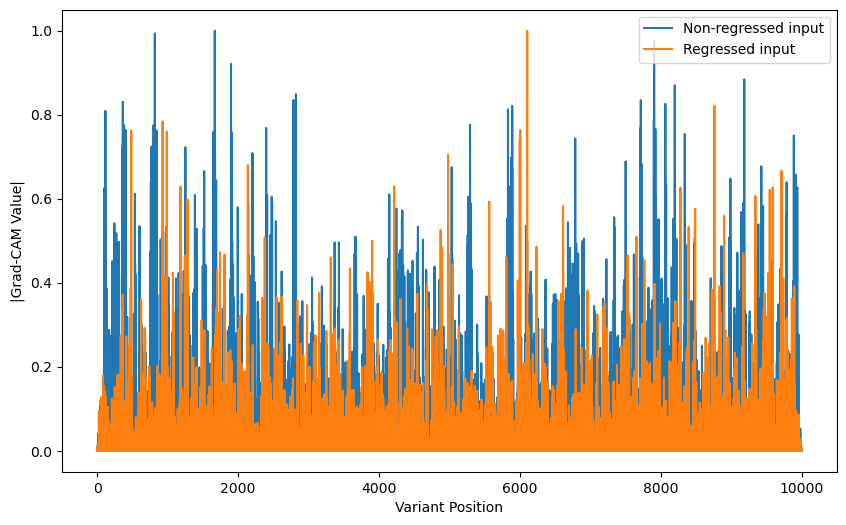

(array([[[-0.0000000e+00],
         [-0.0000000e+00],
         [ 2.6465868e-06],
         ...,
         [ 0.0000000e+00],
         [ 0.0000000e+00],
         [ 0.0000000e+00]]], dtype=float32),
 array([[[-0.        ],
         [-0.        ],
         [-0.00167124],
         ...,
         [ 0.        ],
         [-0.        ],
         [ 0.        ]]], dtype=float32))

In [123]:
plot_gradCam_ind_overlay(X_test, resid_test, y_test, 5, loaded_model_nonRegress, loaded_model_regress)

# FROM FLATTEN LAYER ANALYSES

In [152]:
from tensorflow.keras.models import load_model

loaded_model_non_regressed = load_model("/media/gdagasso/TOSHIBA EXT/simulatedTraits_popStruc/Models/cnn_1d_binaryClassifier_10000_1000inds_lr1e3_epoch2_loss0.5639_acc0.8841_20240403_135559.h5")#""/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/cnn_1d_binaryClassifier_noOHE_lr1e3_epoch5_loss0.5344_acc0.8725_20240216_112515.h5")#"/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/cnn_1d_binaryClassifier.h5_epoch4_loss0.7019_acc0.7647_20240214_191738.h5")
loaded_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputA (InputLayer)         [(None, 10000, 1)]        0         
                                                                 
 conv1G (Conv1D)             (None, 9970, 16)          512       
                                                                 
 batch_normalization_4 (Batc  (None, 9970, 16)         64        
 hNormalization)                                                 
                                                                 
 pool1G (MaxPooling1D)       (None, 1661, 16)          0         
                                                                 
 conv2G (Conv1D)             (None, 1647, 32)          7712      
                                                                 
 batch_normalization_5 (Batc  (None, 1647, 32)         128       
 hNormalization)                                           

# Intermediate Model 

In [124]:
inter_model = intermediate_model("flatten_2",loaded_model)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputA (InputLayer)         [(None, 10000, 1)]        0         
                                                                 
 conv1G (Conv1D)             (None, 9970, 16)          512       
                                                                 
 batch_normalization_4 (Batc  (None, 9970, 16)         64        
 hNormalization)                                                 
                                                                 
 pool1G (MaxPooling1D)       (None, 1661, 16)          0         
                                                                 
 conv2G (Conv1D)             (None, 1647, 32)          7712      
                                                                 
 batch_normalization_5 (Batc  (None, 1647, 32)         128       
 hNormalization)                                             

In [125]:
train_data_features = get_outputs(inter_model,X_train)
test_data_features = get_outputs(inter_model, X_test)
valid_data_features = get_outputs(inter_model, X_valid)

11/11 [==============================] - 0s 2ms/step
(322, 17568)
3/3 [==============================] - 0s 1ms/step
(69, 17568)
3/3 [==============================] - 0s 1ms/step
(69, 17568)


In [ ]:
# non regressed 

In [ ]:
binary_predictor_model = binary_predictor_model_noOHE(flatten_feature_size)

In [181]:
model_file_path = "/media/gdagasso/TOSHIBA EXT/simulatedTraits_popSruc/Models/"
model_name = "cnn_1d_binaryClassifier_nonregressedAtflatten_lr1e3"
#model_regressed = "mlp_regressed_cnn_output.h5"

cnn_model_path = model_file_path + model_name

#regressed_model_path = model_file_path + model_regressed
from datetime import datetime

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"{cnn_model_path}_epoch{{epoch}}_loss{{val_loss:.4f}}_acc{{val_accuracy:.4f}}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.h5"
                                                         , monitor='val_loss', verbose=2, save_best_only=True, include_optimizer=True, save_weights_only=False, mode='auto',
                                                         save_freq='epoch')

Current Time = 16:32:13


In [183]:
history = binary_predictor_model.fit(
    train_data_features,
    y_train,
    validation_data=(valid_data_features,y_valid),
    epochs=80,
    batch_size=10,
    shuffle=False,
    verbose =2,
    callbacks=[checkpoint_callback]
)

Epoch 1/80

Epoch 1: val_loss improved from inf to 0.77617, saving model to /media/gdagasso/TOSHIBA EXT/simulatedTraits_popSruc/Models/cnn_1d_binaryClassifier_nonregressedAtflatten_lr1e3_epoch1_loss0.7762_acc0.8841_20240403_163213.h5
33/33 - 0s - loss: 0.1179 - accuracy: 0.9752 - precision: 0.9665 - recall: 0.9886 - val_loss: 0.7762 - val_accuracy: 0.8841 - val_precision: 0.8222 - val_recall: 1.0000 - 200ms/epoch - 6ms/step
Epoch 2/80

Epoch 2: val_loss improved from 0.77617 to 0.67204, saving model to /media/gdagasso/TOSHIBA EXT/simulatedTraits_popSruc/Models/cnn_1d_binaryClassifier_nonregressedAtflatten_lr1e3_epoch2_loss0.6720_acc0.8841_20240403_163213.h5
33/33 - 0s - loss: 0.0244 - accuracy: 0.9938 - precision: 0.9887 - recall: 1.0000 - val_loss: 0.6720 - val_accuracy: 0.8841 - val_precision: 0.8222 - val_recall: 1.0000 - 178ms/epoch - 5ms/step
Epoch 3/80

Epoch 3: val_loss improved from 0.67204 to 0.65327, saving model to /media/gdagasso/TOSHIBA EXT/simulatedTraits_popSruc/Models/c

33/33 - 0s - loss: 5.7275e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.1581 - val_accuracy: 0.8841 - val_precision: 0.8222 - val_recall: 1.0000 - 67ms/epoch - 2ms/step
Epoch 31/80

Epoch 31: val_loss did not improve from 0.39030
33/33 - 0s - loss: 6.1926e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.1500 - val_accuracy: 0.8841 - val_precision: 0.8222 - val_recall: 1.0000 - 66ms/epoch - 2ms/step
Epoch 32/80

Epoch 32: val_loss did not improve from 0.39030
33/33 - 0s - loss: 1.0870e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.1151 - val_accuracy: 0.8841 - val_precision: 0.8222 - val_recall: 1.0000 - 67ms/epoch - 2ms/step
Epoch 33/80

Epoch 33: val_loss did not improve from 0.39030
33/33 - 0s - loss: 6.7647e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.1100 - val_accuracy: 0.8841 - val_precision: 0.8222 - val_recall: 1.0000 - 67ms/epoch - 2ms/step
Epoch 34/80

Epoch 34: val_lo

Epoch 62/80

Epoch 62: val_loss did not improve from 0.39030
33/33 - 0s - loss: 4.2449e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.1948 - val_accuracy: 0.8841 - val_precision: 0.8222 - val_recall: 1.0000 - 66ms/epoch - 2ms/step
Epoch 63/80

Epoch 63: val_loss did not improve from 0.39030
33/33 - 0s - loss: 4.3715e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.1803 - val_accuracy: 0.8841 - val_precision: 0.8222 - val_recall: 1.0000 - 66ms/epoch - 2ms/step
Epoch 64/80

Epoch 64: val_loss did not improve from 0.39030
33/33 - 0s - loss: 4.4168e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.1843 - val_accuracy: 0.8841 - val_precision: 0.8222 - val_recall: 1.0000 - 66ms/epoch - 2ms/step
Epoch 65/80

Epoch 65: val_loss did not improve from 0.39030
33/33 - 0s - loss: 3.1440e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.1845 - val_accuracy: 0.8841 - val_precision: 0.8222 - val_recall:

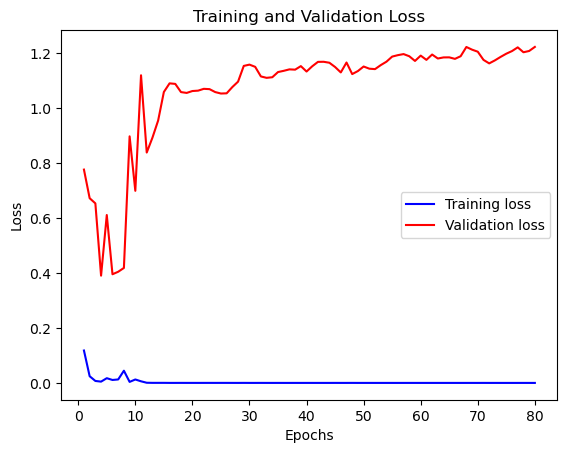

In [184]:
plot_loss(history)

In [189]:
from tensorflow.keras.models import load_model

loaded_model = load_model("/media/gdagasso/TOSHIBA EXT/simulatedTraits_popStruc/Models/cnn_1d_binaryClassifier_nonregressedAtflatten_lr1e3_epoch4_loss0.3903_acc0.8986_20240403_163213.h5")#""/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/cnn_1d_binaryClassifier_noOHE_lr1e3_epoch5_loss0.5344_acc0.8725_20240216_112515.h5")#"/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/cnn_1d_binaryClassifier.h5_epoch4_loss0.7019_acc0.7647_20240214_191738.h5")
loaded_model.summary()

Model: "binary_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 17568)]           0         
                                                                 
 dense_20 (Dense)            (None, 512)               8995328   
                                                                 
 dense_21 (Dense)            (None, 256)               131328    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_22 (Dense)            (None, 128)               32896     
                                                                 
 dense_23 (Dense)            (None, 1)                 129       
                                                                 
Total params: 9,159,681
Trainable params: 9,159,68

In [190]:
#predictions = loaded_model.predict(X_test)
predictions_binary = convert_preds(test_data_features,loaded_model)

#print("predictions2 ", predictions_binary.size)
#print("labels", test['PD.x'].values.size)

my_confusion_matrix(y_test,predictions_binary)

3/3 [==============================] - 0s 2ms/step
[[0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]]
Accuracy: 0.9130434782608695
Confusion Matrix:
 [[28  3]
 [ 3 35]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.90      0.90        31
         1.0       0.92      0.92      0.92        38

    accuracy                           0.91        69
   macro avg       0.91      0.91      0.91        69
weighted avg       0.91      0.91      0.91        69



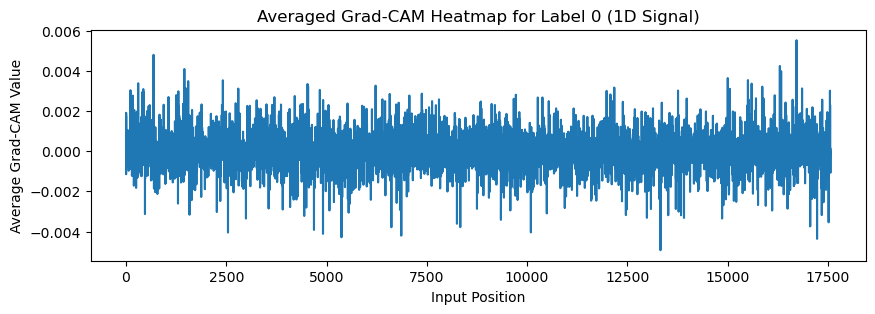

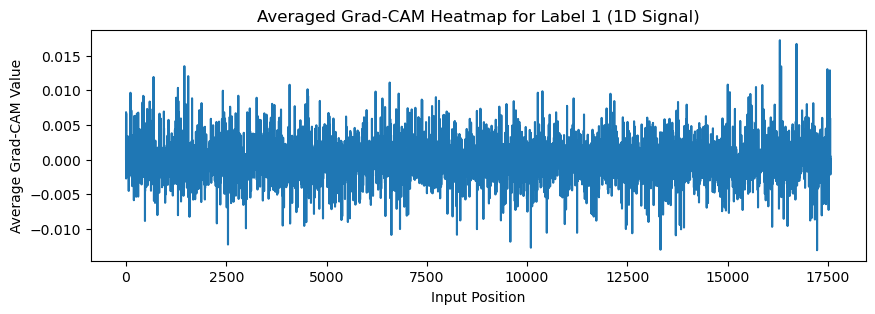

In [191]:
avg_grad_cam_0 = plot_gradCam_average(test_data_features, y_test, 0, loaded_model)
avg_grad_cam_1 = plot_gradCam_average(test_data_features,y_test,1,loaded_model)

# Residualise

In [158]:
from sklearn.linear_model import LinearRegression
# REGRESSION

# Residuals
# Initialize empty arrays to store residuals
resid_train = np.zeros_like(train_data_features)
resid_test = np.zeros_like(test_data_features)
resid_valid = np.zeros_like(valid_data_features)


# Loop through each feature in the features from flatten layer ie chr 5 flatten layer is 13504
for i in range(train_data_features.shape[1]):
    #y = layers.Dense(units=20, activation="linear")(population_structure_input)
    
    # fit linear model for current feature[i]
    lm = LinearRegression().fit(X_train_popStruc, train_data_features[:,i])
    
    # predict features explained by population structure
    p_train = lm.predict(X_train_popStruc)#train_data_all_r_features[:,i])
    p_test = lm.predict(X_test_popStruc)#test_data_all_r_features[:,i])
    p_valid= lm.predict(X_valid_popStruc)#valid_data_all_r_features[:,i])
    
    
    # calculate residuals 
    resid_train[:, i] =  train_data_features[:,i] - p_train
    resid_test[:, i] =  test_data_features[:,i] - p_test
    resid_valid [:, i]=  valid_data_features[:,i] - p_valid
    

In [159]:
print(resid_train.shape)
flatten_feature_size = resid_train.shape[1]

(322, 17568)


# Binary Predictor Model 

In [174]:
binary_predictor_model = binary_predictor_model_noOHE(flatten_feature_size)

Model: "binary_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 17568)]           0         
                                                                 
 dense_20 (Dense)            (None, 512)               8995328   
                                                                 
 dense_21 (Dense)            (None, 256)               131328    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_22 (Dense)            (None, 128)               32896     
                                                                 
 dense_23 (Dense)            (None, 1)                 129       
                                                                 
Total params: 9,159,681
Trainable params: 9,159,68

/home/gdagasso/anaconda3/envs/anomalyDetectionTF/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [175]:
model_file_path = "/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/"
model_name = "cnn_1d_binaryClassifier_regressedAtflatten_lr1e3"
#model_regressed = "mlp_regressed_cnn_output.h5"

cnn_model_path = model_file_path + model_name

#regressed_model_path = model_file_path + model_regressed
from datetime import datetime

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"{cnn_model_path}_epoch{{epoch}}_loss{{val_loss:.4f}}_acc{{val_accuracy:.4f}}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.h5"
                                                         , monitor='val_loss', verbose=2, save_best_only=True, include_optimizer=True, save_weights_only=False, mode='auto',
                                                         save_freq='epoch')

Current Time = 16:23:17


In [176]:
history = binary_predictor_model.fit(
    resid_train,
    y_train,
    validation_data=(resid_valid,y_valid),
    epochs=80,
    batch_size=10,
    shuffle=False,
    verbose =2,
    callbacks=[checkpoint_callback]
)

Epoch 1/80

Epoch 1: val_loss improved from inf to 0.66358, saving model to /media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/cnn_1d_binaryClassifier_regressedAtflatten_lr1e3_epoch1_loss0.6636_acc0.5797_20240403_162317.h5
33/33 - 1s - loss: 0.6874 - accuracy: 0.5280 - precision: 0.5635 - recall: 0.5829 - val_loss: 0.6636 - val_accuracy: 0.5797 - val_precision: 0.6000 - val_recall: 0.6486 - 513ms/epoch - 16ms/step
Epoch 2/80

Epoch 2: val_loss improved from 0.66358 to 0.65527, saving model to /media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/cnn_1d_binaryClassifier_regressedAtflatten_lr1e3_epoch2_loss0.6553_acc0.5507_20240403_162317.h5
33/33 - 0s - loss: 0.5628 - accuracy: 0.7609 - precision: 0.7356 - recall: 0.8743 - val_loss: 0.6553 - val_accuracy: 0.5507 - val_precision: 0.5714 - val_recall: 0.6486 - 166ms/epoch - 5ms/step
Epoch 3/80

Epoch 3: val_loss improved from 0.65527 to 0.65017, saving model to /media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStru

Epoch 24/80

Epoch 24: val_loss did not improve from 0.62642
33/33 - 0s - loss: 0.0656 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.6318 - val_accuracy: 0.6232 - val_precision: 0.6122 - val_recall: 0.8108 - 65ms/epoch - 2ms/step
Epoch 25/80

Epoch 25: val_loss did not improve from 0.62642
33/33 - 0s - loss: 0.0634 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.6316 - val_accuracy: 0.6232 - val_precision: 0.6122 - val_recall: 0.8108 - 66ms/epoch - 2ms/step
Epoch 26/80

Epoch 26: val_loss did not improve from 0.62642
33/33 - 0s - loss: 0.0587 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.6317 - val_accuracy: 0.6232 - val_precision: 0.6122 - val_recall: 0.8108 - 66ms/epoch - 2ms/step
Epoch 27/80

Epoch 27: val_loss did not improve from 0.62642
33/33 - 0s - loss: 0.0526 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.6337 - val_accuracy: 0.6232 - val_precision: 0.6122 - val_recall: 0.8108 - 64ms/e

Epoch 57/80

Epoch 57: val_loss did not improve from 0.62642
33/33 - 0s - loss: 0.0089 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.6688 - val_accuracy: 0.6377 - val_precision: 0.6250 - val_recall: 0.8108 - 68ms/epoch - 2ms/step
Epoch 58/80

Epoch 58: val_loss did not improve from 0.62642
33/33 - 0s - loss: 0.0103 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.6657 - val_accuracy: 0.6377 - val_precision: 0.6250 - val_recall: 0.8108 - 65ms/epoch - 2ms/step
Epoch 59/80

Epoch 59: val_loss did not improve from 0.62642
33/33 - 0s - loss: 0.0082 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.6681 - val_accuracy: 0.6377 - val_precision: 0.6250 - val_recall: 0.8108 - 65ms/epoch - 2ms/step
Epoch 60/80

Epoch 60: val_loss did not improve from 0.62642
33/33 - 0s - loss: 0.0078 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.6696 - val_accuracy: 0.6377 - val_precision: 0.6250 - val_recall: 0.8108 - 66ms/e

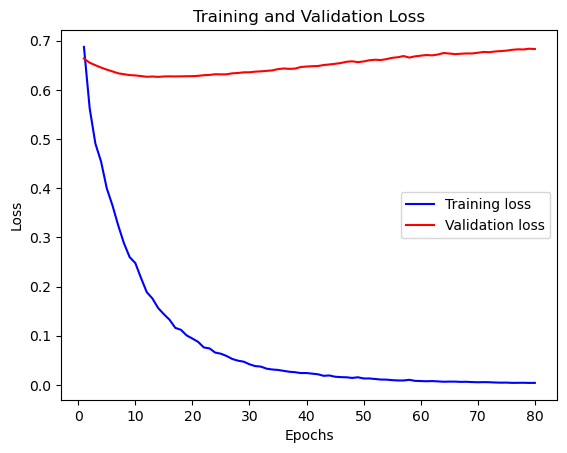

In [177]:
plot_loss(history)

In [178]:
from tensorflow.keras.models import load_model

loaded_model = load_model("/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/cnn_1d_binaryClassifier_regressedAtflatten_lr1e3_epoch80_loss0.4599_acc0.7826_20240403_162222.h5")#""/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/cnn_1d_binaryClassifier_noOHE_lr1e3_epoch5_loss0.5344_acc0.8725_20240216_112515.h5")#"/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/cnn_1d_binaryClassifier.h5_epoch4_loss0.7019_acc0.7647_20240214_191738.h5")
loaded_model.summary()

Model: "binary_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 17568, 1)]        0         
                                                                 
 flatten_4 (Flatten)         (None, 17568)             0         
                                                                 
 dense_16 (Dense)            (None, 512)               8995328   
                                                                 
 dense_17 (Dense)            (None, 256)               131328    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_18 (Dense)            (None, 128)               32896     
                                                                 
 dense_19 (Dense)            (None, 1)            

In [179]:
#predictions = loaded_model.predict(X_test)
predictions_binary = convert_preds(resid_test,loaded_model)

#print("predictions2 ", predictions_binary.size)
#print("labels", test['PD.x'].values.size)

my_confusion_matrix(y_test,predictions_binary)

3/3 [==============================] - 0s 1ms/step
[[1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]]
Accuracy: 0.7681159420289855
Confusion Matrix:
 [[20 11]
 [ 5 33]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.65      0.71        31
         1.0       0.75      0.87      0.80        38

    accuracy                           0.77        69
   macro avg       0.78      0.76      0.76        69
weighted avg       0.77      0.77      0.76        69



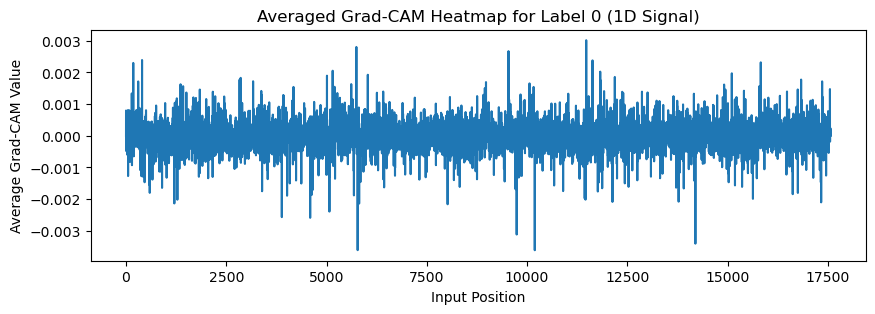

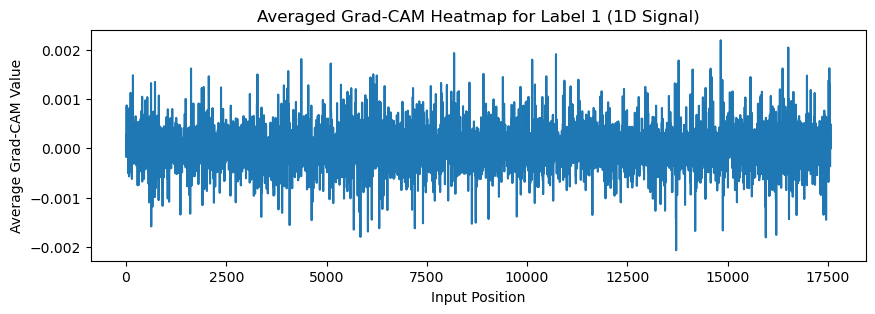

In [180]:
avg_grad_cam_0 = plot_gradCam_average(resid_test, y_test, 0, loaded_model)
avg_grad_cam_1 = plot_gradCam_average(resid_test,y_test,1,loaded_model)

In [ ]:
print_peaks(geno_df_0, avg_grad_cam_0, threshold = 0.004)
print_peaks(geno_df_0, avg_grad_cam_1, threshold = 0.01)